In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 지도 데이터 분석 라이브러리
import fiona
import geopandas
import shapely.wkt # geometry type으로 변경해주는 라이브러리

# 데이터 분석 라이브러리
import pandas as pd
import numpy as np
import os

# 데이터 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import style
import seaborn as sns
import folium
from folium.plugins import HeatMap

# 웹크롤링을 위한 라이브러리
import requests
import lxml
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import time

In [3]:
# matplotlib 한글 지원 폰트 설정
plt.rc("font", family="Malgun Gothic")

### 세종시 지도 시각화

In [4]:
geo = geopandas.read_file('./dataset/전처리전/세종시_읍면동_경계.geojson', encoding='utf-8')
geo = geo[geo['sidonm'] == '세종특별자치시']

In [5]:
geo.head()

OBJECTID            adm_nm   adm_cd     adm_cd2    sgg sido   sidonm  \
1136      1143  세종특별자치시 세종시 조치원읍  2901011  3611025000  36110   36  세종특별자치시   
1137      1145   세종특별자치시 세종시 연동면  2901032  3611032000  36110   36  세종특별자치시   
1138      1146   세종특별자치시 세종시 부강면  2901033  3611033000  36110   36  세종특별자치시   
1139      1148   세종특별자치시 세종시 장군면  2901035  3611035000  36110   36  세종특별자치시   
1140      1149   세종특별자치시 세종시 연서면  2901036  3611036000  36110   36  세종특별자치시   

          temp sggnm   adm_cd8  \
1136  세종시 조치원읍   세종시  29010110   
1137   세종시 연동면   세종시  29010320   
1138   세종시 부강면   세종시  29010330   
1139   세종시 장군면   세종시  29010350   
1140   세종시 연서면   세종시  29010360   

                                               geometry  
1136  MULTIPOLYGON (((127.30161 36.58212, 127.30141 ...  
1137  MULTIPOLYGON (((127.32190 36.58265, 127.32196 ...  
1138  MULTIPOLYGON (((127.37706 36.56744, 127.37617 ...  
1139  MULTIPOLYGON (((127.21853 36.55281, 127.21882 ...  
1140  MULTIPOLYGON (((127.25867 36.61878, 127.25964 ...

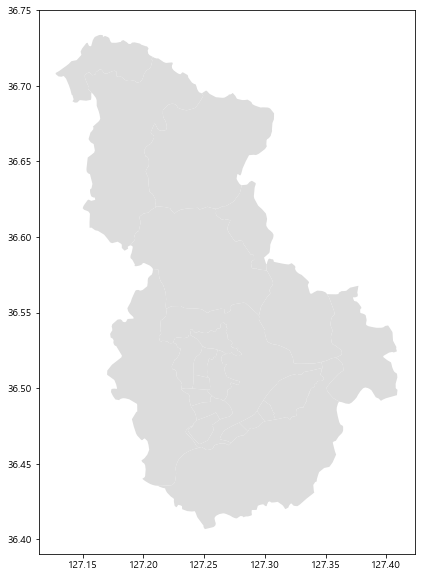

In [7]:
plt.rcParams["figure.figsize"] = (10,10)
ax = geo.plot(column='adm_cd', color='gainsboro')
#ax.set_axis_off() # x, y축 시각화 제거
plt.show()

### 세종시 인구밀도 (100m x 100m) 시각화

In [8]:
c = fiona.open('./dataset/전처리전/202204_세종시_인구_격자_100m/세종시_인구_격자_100m.shp', encoding='utf8')
population_100m = geopandas.GeoDataFrame.from_features(c, crs=c.crs).to_crs('epsg:5179')
population_100m.head()

geometry       gid    lbl   val
0  POLYGON ((977800.000 1828600.000, 977800.000 1...  다바778286    N/A   0.0
1  POLYGON ((990100.000 1837300.000, 990100.000 1...  다바901373    N/A   0.0
2  POLYGON ((980600.000 1843000.000, 980600.000 1...  다바806430  27.00  27.0
3  POLYGON ((983800.000 1830600.000, 983800.000 1...  다바838306    N/A   0.0
4  POLYGON ((969300.000 1857700.000, 969300.000 1...  다바693577  27.00  27.0

In [9]:
population_100m = population_100m[['geometry', 'val']]
population_100m.fillna(0).head()

geometry   val
0  POLYGON ((977800.000 1828600.000, 977800.000 1...   0.0
1  POLYGON ((990100.000 1837300.000, 990100.000 1...   0.0
2  POLYGON ((980600.000 1843000.000, 980600.000 1...  27.0
3  POLYGON ((983800.000 1830600.000, 983800.000 1...   0.0
4  POLYGON ((969300.000 1857700.000, 969300.000 1...  27.0

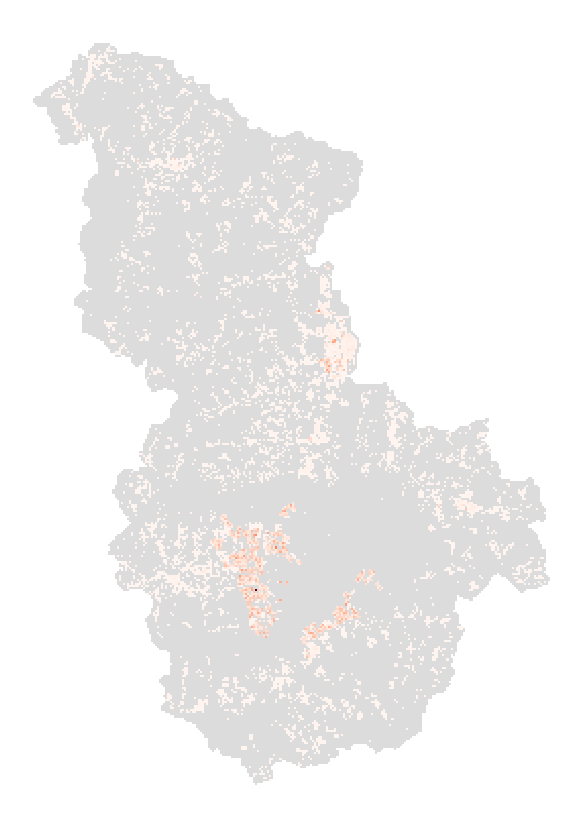

In [10]:
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white') ## 캔버스 색상 설정

population_100m.plot(ax=ax1, color='gainsboro')
population_100m.plot(ax=ax1, column='val', cmap='Reds')
ax1.set_axis_off()
plt.show()

#### 인구 밀도 확인이 어려움 -> 데이터 확인

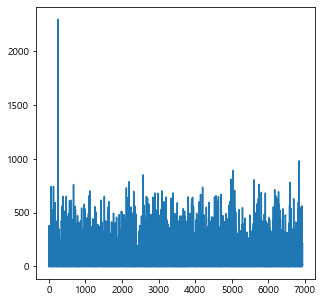

In [12]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(population_100m['val'])
plt.show()

In [13]:
population_100m[population_100m['val'] > 1000]

geometry     val
250  POLYGON ((977600.000 1832700.000, 977600.000 1...  2296.0

#### 확인이 더 쉽도록 인구가 유난히 높은 곳을 제거

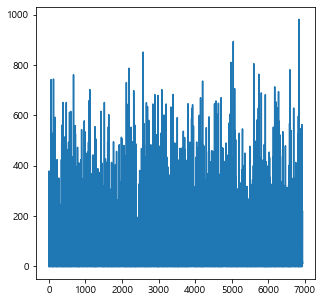

In [14]:
po_100m_1 = population_100m.drop(population_100m[population_100m['val']>1000].index)
plt.plot(po_100m_1['val'])
plt.show()

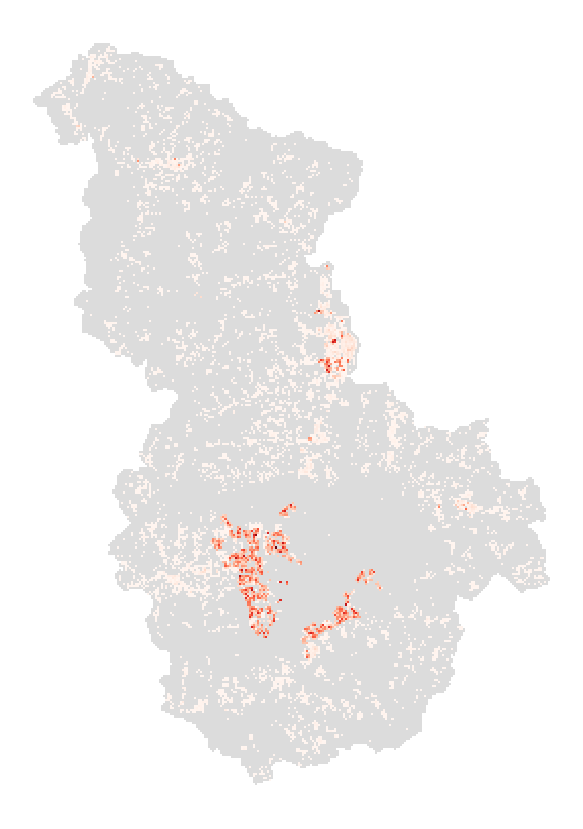

In [15]:
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white') ## 캔버스 색상 설정

po_100m_1.plot(ax=ax1, color='gainsboro')
po_100m_1.plot(ax=ax1, column='val', cmap='Reds')
ax1.set_axis_off()
plt.show()

### 세종시 건축물수 (100m x 100m) 시각화

In [16]:
c = fiona.open('./dataset/전처리전/202205_세종시_건축물수_격자_100m/세종시_건축물수_100m.shp', encoding='utf-8')
structure_100m = geopandas.GeoDataFrame.from_features(c, crs=c.crs).to_crs('epsg:5179')
structure_100m.head()

geometry       gid    lbl   val
0  POLYGON ((990100.000 1837300.000, 990100.000 1...  다바901373   1.00   1.0
1  POLYGON ((969300.000 1857700.000, 969300.000 1...  다바693577  20.00  20.0
2  POLYGON ((977800.000 1828800.000, 977800.000 1...  다바778288   2.00   2.0
3  POLYGON ((975800.000 1835000.000, 975800.000 1...  다바758350   3.00   3.0
4  POLYGON ((971500.000 1853500.000, 971500.000 1...  다바715535   1.00   1.0

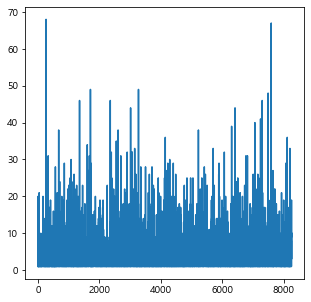

In [17]:
structure_100m.fillna(0)

fig = plt.subplots(figsize=(5, 5))
plt.plot(structure_100m['val'])
plt.show()

#### 시각화를 위해 이상치 제거

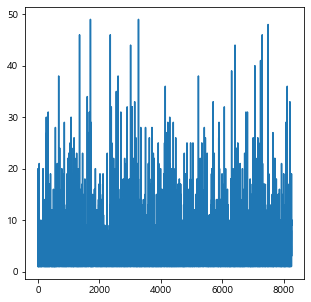

In [18]:
st_100m_1 = structure_100m.drop(structure_100m[structure_100m['val']>60].index)
fig = plt.subplots(figsize=(5, 5))
plt.plot(st_100m_1['val'])
plt.show()

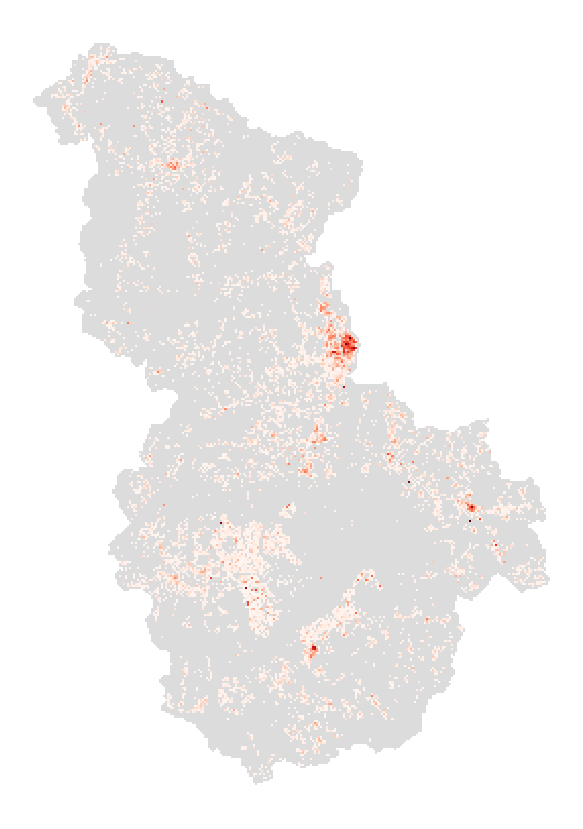

In [19]:
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white') ## 캔버스 색상 설정

st_100m_1.plot(ax=ax1, color='gainsboro')
st_100m_1.plot(ax=ax1, column='val', cmap='Reds')
ax1.set_axis_off()
plt.show()

### 세종시 주차장 접근성 (500m x 500m)

In [20]:
c = fiona.open('C:/Users/sajah/Desktop/develop/python/데이터청년캠퍼스/프로젝트/데이터/2020_세종시_주차장_접근성_격자_500m/주차장_접근성.shp', encoding='utf-8')
parking_500m = geopandas.GeoDataFrame.from_features(c, crs=c.crs).to_crs('epsg:5179')
parking_500m.head()

geometry  id       gid sgg_nm_k  \
0  POLYGON ((776500.000 1567000.000, 776500.000 1...   1  가다76b67a     null   
1  POLYGON ((776500.000 1572000.000, 776500.000 1...   2  가다76b72a     null   
2  POLYGON ((777000.000 1566500.000, 777000.000 1...   3  가다77a66b     null   
3  POLYGON ((777000.000 1567000.000, 777000.000 1...   4  가다77a67a     null   
4  POLYGON ((777000.000 1571500.000, 777000.000 1...   5  가다77a71b     null   

  sgg_nm_e  sgg_cd sido_nm_k sido_nm_e  sido_cd  value  stats_year raw_d_year  
0     null       0      null      null        0 -999.0        2020     202010  
1     null       0      null      null        0 -999.0        2020     202010  
2     null       0      null      null        0 -999.0        2020     202010  
3     null       0      null      null        0 -999.0        2020     202010  
4     null       0      null      null        0 -999.0        2020     202010

In [21]:
pk_500m_1 = parking_500m[parking_500m['sgg_nm_k'].str.contains('세종')]
pk_500m_1.reset_index(drop=False, inplace=True)

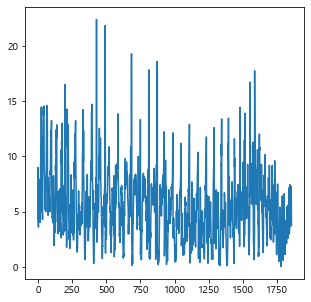

In [22]:
fig = plt.subplots(figsize=(5, 5))
plt.plot(pk_500m_1['value'])
plt.show()

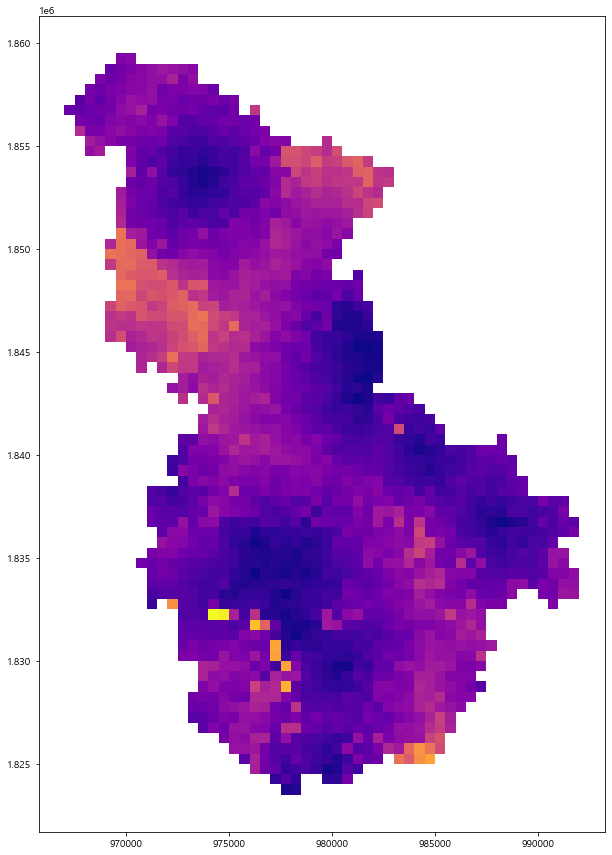

In [27]:
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white') ## 캔버스 색상 설정

pk_500m_1.plot(ax=ax1, color='gainsboro')
pk_500m_1.plot(ax=ax1, column='value', cmap='plasma')

plt.show()

### 위치에 관한 데이터가 POLYGON, 위도/경도, 주소가 존재함

#### POLYGON 좌표로 통일

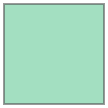

In [28]:
# 인구 격자 100m x 100m 폴리곤 크기
po_100m_1['geometry'][0]

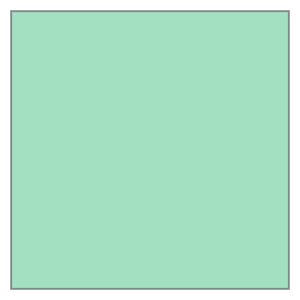

In [29]:
# 주차장 접근성 격자 500m x 500m 폴리곤 크기
parking_500m['geometry'][0]

In [30]:
# POLYGON 데이터 확인

df = pd.DataFrame(structure_100m)
df2 = pd.DataFrame(pk_500m_1)

df['geometry'] = df['geometry'].astype('string')
df2['geometry'] = df2['geometry'].astype('string')

po_100m_1['geometry'][0]
pk_500m_1['geometry'][0]

'POLYGON ((967000 1856500, 967000 1857000, 967500 1857000, 967500 1856500, 967000 1856500))'

In [31]:
# 슬라이싱 예시
int(df['geometry'][0][10:16])

990100

#### 폴리곤 시작점

In [32]:
# 가장 왼쪽의 폴리곤 시작점
poly_left = 1000000
for i, g in enumerate(df['geometry']):
    if int(g[10:16]) < poly_left:
        poly_left = int(g[10:16])

# 가장 아래의 폴리곤 시작점
poly_down = 2000000
for i, g in enumerate(df['geometry']):
    if int(g[17:24]) < poly_down:
        poly_down = int(g[17:24])

# 가장 위의 폴리곤 시작점
poly_up = 1800000
for i, g in enumerate(df['geometry']):
    if int(g[33:40]) > poly_up:
        poly_up = int(g[33:40])
        
# 가장 오른쪽의 폴리곤 시작점
poly_right = 900000
for i, g in enumerate(df['geometry']):
    if int(g[42:48]) > poly_right:
        poly_right = int(g[42:48])

print('poly_left', poly_left)
print('poly_down', poly_down)
print('poly_up', poly_up)
print('poly_right', poly_right)

poly_left 966700
poly_down 1823200
poly_up 1859600
poly_right 992100


In [27]:
print('가로길이', poly_right-poly_left)
print('세로길이', poly_up-poly_down)
print('세종시는 254 * 364의 격자로 표현 가능 (100m x 100m)')

가로길이 25400
세로길이 36400
세종시는 254 * 364의 격자로 표현 가능 (100m x 100m)


In [28]:
# geo데이터는 타입을 변경해야 수정가능

df3 = pd.DataFrame(geo)
df3['geometry'] = df3['geometry'].astype('string')
df3.reset_index(drop=False, inplace=True)

In [29]:
# 슬라이싱 예시
df3['geometry'][0][16:-3].split(', ')[0].split()

['127.30161101266826', '36.582124381608836']

In [30]:
# 세종시는 결과의 위도와 경도 범위에 있음

latitude = []
longitude = []

for g in df3['geometry']:
    for l in g[16:-3].split(', '):
        longitude.append(l.split()[0])
        latitude.append(l.split()[1])
    
print('latitude : ', min(latitude), "~", max(latitude))
print('longitude : ', min(longitude), "~", max(longitude))

latitude :  36.40675835257603 ~ 36.73376199366808
longitude :  127.12765872447403 ~ 127.4092754044858


### Output으로 사용할 충전소 위치 전처리

In [95]:
ev_charger = pd.read_csv('./dataset/전처리전/충전소 리스트.csv', encoding='utf-8')
ev_charger.head()

운영기관                          충전소  충전기ID 충전기타입     지역   시군구  \
0  환경부(한국자동차환경협회)                  신북보건지소공영주차장     21  DC콤보  전라남도   영암군    
1  환경부(한국자동차환경협회)                  신북보건지소공영주차장     22  DC콤보  전라남도   영암군    
2  환경부(한국자동차환경협회)   한국생산기술연구원 대경본부바이오메디칼생산기술센터      1  DC콤보  경상북도   영천시    
3  환경부(한국자동차환경협회)   한국생산기술연구원 대경본부바이오메디칼생산기술센터      2  DC콤보  경상북도   영천시    
4  환경부(한국자동차환경협회)                (구)거진수산센터 주차장     11  DC콤보   강원도   고성군    

                       주소     이용가능시간 이용자 제한         충전용량   비고  
0  전라남도 영암군 신북면 간은정로 21-7  24시간 이용가능    NaN  급속(200kW동시)  NaN  
1  전라남도 영암군 신북면 간은정로 21-7  24시간 이용가능    NaN  급속(200kW동시)  NaN  
2         경상북도 영천시 양호길 59  24시간 이용가능    NaN  급속(100kW단독)  NaN  
3         경상북도 영천시 양호길 59  24시간 이용가능    NaN  급속(100kW단독)  NaN  
4   강원도 고성군 거진읍 거진리 22-93  24시간 이용가능    NaN  급속(200kW동시)  NaN

#### 세종시는 1380개의 충전기가 존재

In [96]:
ev_charger_sg = ev_charger[ev_charger['지역'] == '세종특별자치시 ']
len(ev_charger_sg)

1380

In [97]:
ev_charger_sg.head()

운영기관                충전소  충전기ID 충전기타입        지역   시군구  \
44   환경부(한국자동차환경협회)            LH 세종본부     11  DC콤보  세종특별자치시   가름로    
45   환경부(한국자동차환경협회)            LH 세종본부     12  DC콤보  세종특별자치시   가름로    
420  환경부(한국자동차환경협회)  고복저수지 연기대첩비공원 주차장      1  DC콤보  세종특별자치시   연서면    
973  환경부(한국자동차환경협회)         금암리마을회관주차장     21  DC콤보  세종특별자치시   장군면    
974  환경부(한국자동차환경협회)         금암리마을회관주차장     22  DC콤보  세종특별자치시   장군면    

                        주소     이용가능시간 이용자 제한         충전용량   비고  
44       세종특별자치시 가름로 238-1  24시간 이용가능    NaN  급속(200kW동시)  NaN  
45       세종특별자치시 가름로 238-1  24시간 이용가능    NaN  급속(200kW동시)  NaN  
420  세종특별자치시 연서면 용암리 208-5  24시간 이용가능    NaN  급속(100kW멀티)  NaN  
973     세종특별자치시 장군면 정자말길 6  24시간 이용가능    NaN  급속(200kW동시)  NaN  
974     세종특별자치시 장군면 정자말길 6  24시간 이용가능    NaN  급속(200kW동시)  NaN

#### 세종시는 347개 충전소가 있다고 우선 판단 가능

In [98]:
ev_charger_sg_dd = ev_charger_sg.drop_duplicates(['주소'])
len(ev_charger_sg_dd)

347

In [99]:
ev_charger_sg_dd.head()

운영기관                충전소  충전기ID 충전기타입        지역    시군구  \
44    환경부(한국자동차환경협회)            LH 세종본부     11  DC콤보  세종특별자치시    가름로    
420   환경부(한국자동차환경협회)  고복저수지 연기대첩비공원 주차장      1  DC콤보  세종특별자치시    연서면    
973   환경부(한국자동차환경협회)         금암리마을회관주차장     21  DC콤보  세종특별자치시    장군면    
1666  환경부(한국자동차환경협회)        도담동 싱싱장터주차장     21  DC콤보  세종특별자치시   보듬6로    
2196  환경부(한국자동차환경협회)     명학일반산업단지 관리사무소     21  DC콤보  세종특별자치시    연동면    

                         주소     이용가능시간 이용자 제한         충전용량            비고  
44        세종특별자치시 가름로 238-1  24시간 이용가능    NaN  급속(200kW동시)           NaN  
420   세종특별자치시 연서면 용암리 208-5  24시간 이용가능    NaN  급속(100kW멀티)           NaN  
973      세종특별자치시 장군면 정자말길 6  24시간 이용가능    NaN  급속(200kW동시)           NaN  
1666        세종특별자치시 보듬6로 16  24시간 이용가능    NaN  급속(200kW동시)  주간 유료, 야간 무료  
2196    세종특별자치시 연동면 응암리 916  24시간 이용가능    NaN  급속(200kW동시)           NaN

### 주소를 검색하여 위도, 경도를 찾는 웹 크롤링

In [100]:
location = []

browser = webdriver.Chrome('./dataset/chromedriver.exe')

for addr in ev_charger_sg_dd['주소']:
    '''
    addr = addr.split()
    temp = ''
    
    for i, a in enumerate(addr):
        temp += a
        if i < len(addr)-1:
            temp += '+'
    '''
            
    url = 'https://map.naver.com/v5/search/' + addr
    
    browser.get(url)
    time.sleep(2)
    current_url = browser.current_url
    
    browser.get('https://xn--yq5bk9r.com/blog/map-coordinates')
    elem = browser.find_element(By.XPATH, '//*[@id="__next"]/div/div/main/div[3]/article/div/div/div/div[1]/div/div[2]/div[1]/input')
    elem.send_keys(current_url + Keys.TAB + Keys.ENTER)
    time.sleep(3)
    
    try:
        location_text = browser.find_element(By.XPATH, '//*[@id="__next"]/div/div/main/div[3]/article/div/div/div/div[1]/div/div[2]/div[2]/div/div[1]').text
        
    except:
        location_text = '좌표 : 위도 : 0, 경도 : 0'

    print(location_text)
    location.append((location_text.split()[4][:-1], location_text.split()[-1]))

browser.quit()

좌표 : 위도 : 36.49468870000027, 경도 : 127.2645932999995
좌표 : 위도 : 36.59959349999978, 경도 : 127.22725089999949
좌표 : 위도 : 36.438385000000245, 경도 : 127.22032839999963
좌표 : 위도 : 36.51548869999969, 경도 : 127.25912020000005
좌표 : 위도 : 36.54077219999998, 경도 : 127.33563749999936
좌표 : 위도 : 36.543736699999826, 경도 : 127.32968869999964
좌표 : 위도 : 36.49216990000007, 경도 : 127.29946630000012
좌표 : 위도 : 36.4821080999997, 경도 : 127.29089679999969
좌표 : 위도 : 36.435701300000076, 경도 : 127.22860249999991
좌표 : 위도 : 36.48461169999969, 경도 : 127.25199279999987
좌표 : 위도 : 36.599767099999795, 경도 : 127.29931299999954
좌표 : 위도 : 36.49963870000011, 경도 : 127.25910079999935
좌표 : 위도 : 36.50529750000008, 경도 : 127.26095849999983
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 36.49806300000027, 경도 : 127.28160509999972
좌표 : 위도 : 36.50282000000027, 경도 : 127.26986009999942
좌표 : 위도 : 36.506005099999676, 경도 : 127.26428989999955
좌표 : 위도 : 36.50595540000003, 경도 : 127.25851609999992
좌표 : 위도 : 36.50029780000004, 경도 : 127.268210

좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 36.51357979999962, 경도 : 127.26081489999963
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.32122999999983, 경도 : 127.12472569999932
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 36.4839502000001, 경도 : 127.2926292999997
좌표 : 위도 : 0, 경도 : 0
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 0, 경도

In [101]:
location[:5]

[('36.49468870000027', '127.2645932999995'),
 ('36.59959349999978', '127.22725089999949'),
 ('36.438385000000245', '127.22032839999963'),
 ('36.51548869999969', '127.25912020000005'),
 ('36.54077219999998', '127.33563749999936')]

#### GCS 열을 생성하여 위도, 경도를 삽입

In [102]:
ev_charger_sg_dd['GCS'] = location # Geographic Coordinate System
ev_charger_sg_dd.head()

운영기관                충전소  충전기ID 충전기타입        지역    시군구  \
44    환경부(한국자동차환경협회)            LH 세종본부     11  DC콤보  세종특별자치시    가름로    
420   환경부(한국자동차환경협회)  고복저수지 연기대첩비공원 주차장      1  DC콤보  세종특별자치시    연서면    
973   환경부(한국자동차환경협회)         금암리마을회관주차장     21  DC콤보  세종특별자치시    장군면    
1666  환경부(한국자동차환경협회)        도담동 싱싱장터주차장     21  DC콤보  세종특별자치시   보듬6로    
2196  환경부(한국자동차환경협회)     명학일반산업단지 관리사무소     21  DC콤보  세종특별자치시    연동면    

                         주소     이용가능시간 이용자 제한         충전용량            비고  \
44        세종특별자치시 가름로 238-1  24시간 이용가능    NaN  급속(200kW동시)           NaN   
420   세종특별자치시 연서면 용암리 208-5  24시간 이용가능    NaN  급속(100kW멀티)           NaN   
973      세종특별자치시 장군면 정자말길 6  24시간 이용가능    NaN  급속(200kW동시)           NaN   
1666        세종특별자치시 보듬6로 16  24시간 이용가능    NaN  급속(200kW동시)  주간 유료, 야간 무료   
2196    세종특별자치시 연동면 응암리 916  24시간 이용가능    NaN  급속(200kW동시)           NaN   

                                           GCS  
44      (36.49468870000027, 127.2645932999995)  
420    (36.59959349999978, 127.22725089999949)  
973   (36.438385000000245, 127.22032839999963)  
1666   (36.51548869999969, 127.25912020000005)  
2196   (36.54077219999998, 127.33563749999936)

#### 위치를 찾을 수 없는 곳은 (0, 0)으로 표시했는데 주소 이름의 문제로 검색이 안되었음

In [103]:
ev_charger_sg_dd[ev_charger_sg_dd.GCS == ('0', '0')]

운영기관                   충전소  충전기ID       충전기타입        지역  \
5056    환경부(한국자동차환경협회)                정부세종청사      1  DC차데모+AC3상  세종특별자치시    
5057    환경부(한국자동차환경협회)        정부세종청사 공정거래위원회      1        DC콤보  세종특별자치시    
5058    환경부(한국자동차환경협회)            정부세종청사 교육부      1        DC콤보  세종특별자치시    
5059    환경부(한국자동차환경협회)            정부세종청사 국세청      1        DC콤보  세종특별자치시    
5060    환경부(한국자동차환경협회)  정부세종청사 농림축산식품부/해양수산부      1        DC콤보  세종특별자치시    
...                ...                   ...    ...         ...       ...   
129073          한국전자금융             세종 센트럴테라스      1        AC완속  세종특별자치시    
129075          한국전자금융               세종 우빈가온      1        AC완속  세종특별자치시    
129078          한국전자금융              세종 판타지타워      1        AC완속  세종특별자치시    
129081          한국전자금융             세종 펠리체타워1      1        AC완속  세종특별자치시    
129647             에너넷             세종시 네이버타워     13        AC완속  세종특별자치시    

           시군구                                                 주소      이용가능시간  \
5056     다솜2로   세종특별자치시 다솜2로 11, 정부세종청사 종합안내실 정문 우측도보, 정부세종청사 ...  9:00~18:00   
5057     다솜3로            세종특별자치시 다솜3로 95(어진동)세종특별자치시 다솜2로 94(어진동)   24시간 이용가능   
5058      갈매로                                세종특별자치시 갈매로 408(어진동)   24시간 이용가능   
5059     국세청로                              세종특별자치시 국세청로 8-14(나성동)   24시간 이용가능   
5060     다솜2로                                세종특별자치시 다솜2로 94(어진동)   24시간 이용가능   
...        ...                                                ...         ...   
129073   대평4길                   세종특별자치시 대평4길 17센트럴테라스(679 센트럴테라스)   24시간 이용가능   
129075  한누리대로                     세종특별자치시 한누리대로 201우빈가온(715 우빈가온)   24시간 이용가능   
129078  한누리대로                  세종특별자치시 한누리대로 2257판타지타워(699 판타지타워)   24시간 이용가능   
129081    대평로                    세종특별자치시 대평로 71펠리체타워1(687 펠리체타워1)   24시간 이용가능   
129647   호려울로                   세종특별자치시 호려울로 9지하주차장 3층(755 네이버타워)   24시간 이용가능   

       이용자 제한         충전용량                      비고     GCS  
5056      NaN     급속(50kW)  주말, 공휴일: 이용불가/노후로 교체예정  (0, 0)  
5057      NaN  급속(100kW멀티)                     NaN  (0, 0)  
5058      NaN  급속(100kW멀티)                     NaN  (0, 0)  
5059      NaN  급속(100kW멀티)                     NaN  (0, 0)  
5060      NaN  급속(100kW멀티)                     NaN  (0, 0)  
...       ...          ...                     ...     ...  
129073    NaN          7kW                     NaN  (0, 0)  
129075    NaN          7kW                     NaN  (0, 0)  
129078    NaN          7kW                     NaN  (0, 0)  
129081    NaN          7kW                     NaN  (0, 0)  
129647    NaN          7kW                     NaN  (0, 0)  

[224 rows x 12 columns]

#### 주소를 다음과 같이 변경

In [104]:
print(ev_charger_sg_dd['주소'].loc[5057])
print('↓')
print(ev_charger_sg_dd['주소'].loc[5057].split(',')[0].split('(')[0])

세종특별자치시 다솜3로 95(어진동)세종특별자치시 다솜2로 94(어진동)
↓
세종특별자치시 다솜3로 95


In [105]:
browser = webdriver.Chrome('./dataset/chromedriver.exe')

for i in ev_charger_sg_dd[ev_charger_sg_dd.GCS == ('0', '0')].index:
    
    addr = ev_charger_sg_dd['주소'].loc[i].split(',')[0].split('(')[0]
    
    url = 'https://map.naver.com/v5/search/' + addr
    
    browser.get(url)
    time.sleep(2)
    current_url = browser.current_url
    
    browser.get('https://xn--yq5bk9r.com/blog/map-coordinates')
    elem = browser.find_element(By.XPATH, '//*[@id="__next"]/div/div/main/div[3]/article/div/div/div/div[1]/div/div[2]/div[1]/input')
    elem.send_keys(current_url + Keys.TAB + Keys.ENTER)
    time.sleep(3)
    
    try:
        location_text = browser.find_element(By.XPATH, '//*[@id="__next"]/div/div/main/div[3]/article/div/div/div/div[1]/div/div[2]/div[2]/div/div[1]').text
        
    except:
        location_text = '좌표 : 위도 : 0, 경도 : 0'

    print(location_text)    
    ev_charger_sg_dd['GCS'].loc[i] = (location_text.split()[4][:-1], location_text.split()[-1])

browser.quit()

좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 36.504252199999875, 경도 : 127.26643939999992
좌표 : 위도 : 36.49905729999989, 경도 : 127.26457770000002
좌표 : 위도 : 36.485273699999965, 경도 : 127.2582090999997
좌표 : 위도 : 36.50464530000004, 경도 : 127.26364119999936
좌표 : 위도 : 36.49784919999978, 경도 : 127.26427089999979
좌표 : 위도 : 36.484163500000186, 경도 : 127.26039459999943
좌표 : 위도 : 36.48143850000002, 경도 : 127.26159809999973
좌표 : 위도 : 36.48143850000002, 경도 : 127.26159809999973
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 36.5176504999998, 경도 : 127.23681899999987
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 36.50233139999974, 경도 : 127.24834130000015
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌

좌표 : 위도 : 36.50366259999994, 경도 : 127.2316341
좌표 : 위도 : 36.4882669000002, 경도 : 127.26413849999963
좌표 : 위도 : 36.51268190000017, 경도 : 127.25548489999989
좌표 : 위도 : 36.514027699999716, 경도 : 127.25534550000003
좌표 : 위도 : 36.5117880999996, 경도 : 127.25940839999963
좌표 : 위도 : 36.509862699999694, 경도 : 127.26374369999931
좌표 : 위도 : 36.51007020000028, 경도 : 127.25514589999969
좌표 : 위도 : 36.515545200000076, 경도 : 127.25525309999958
좌표 : 위도 : 36.4628486000002, 경도 : 127.27791439999945
좌표 : 위도 : 36.51050460000026, 경도 : 127.24914059999934
좌표 : 위도 : 36.508817699999874, 경도 : 127.2464036999998
좌표 : 위도 : 36.48890949999959, 경도 : 127.24935789999981
좌표 : 위도 : 36.48932500000004, 경도 : 127.25260659999945
좌표 : 위도 : 36.4879080999999, 경도 : 127.25465600000004
좌표 : 위도 : 36.4812728000002, 경도 : 127.24622210000007
좌표 : 위도 : 37.32122999999983, 경도 : 127.12472569999932
좌표 : 위도 : 36.48401030000008, 경도 : 127.25550049999937
좌표 : 위도 : 36.48093169999961, 경도 : 127.30370389999932
좌표 : 위도 : 36.496335800000146, 경도 : 127.2623026999996
좌표

In [106]:
ev_charger_sg_dd.reset_index(drop=False, inplace=True)

#### 여전히 주소를 못 찾은 곳이 있었지만 6개밖에 없어서 직접 수정

In [107]:
ev_charger_sg_dd[ev_charger_sg_dd['GCS'] == ('0', '0')]

Empty DataFrame
Columns: [index, 운영기관, 충전소, 충전기ID, 충전기타입, 지역, 시군구, 주소, 이용가능시간, 이용자 제한, 충전용량, 비고, GCS]
Index: []

In [123]:
ev_charger_sg_dd['GCS'].loc[40] = ('36.5176504999998', '127.23681899999987')
ev_charger_sg_dd['GCS'].loc[149] = ('36.51420640000002', '127.25755629999962')
ev_charger_sg_dd['GCS'].loc[229] = ('36.48445770000006', '127.25655059999953')
ev_charger_sg_dd['GCS'].loc[239] = ('36.50705740000009', '127.23799990000006')
ev_charger_sg_dd['GCS'].loc[275] = ('36.48093169999961', '127.30474989999959')
ev_charger_sg_dd['GCS'].loc[340] = ('36.512851500000224', '127.25414099999965')

In [125]:
ev_charger_sg_dd['GCS'].loc[0]

('36.49468870000027', '127.2645932999995')

#### 모든 주소에 대응하는 좌표를 찾았음을 확인

In [109]:
ev_charger_sg_dd[ev_charger_sg_dd['GCS'] == ('0', '0')]

Empty DataFrame
Columns: [index, 운영기관, 충전소, 충전기ID, 충전기타입, 지역, 시군구, 주소, 이용가능시간, 이용자 제한, 충전용량, 비고, GCS]
Index: []

#### 데이터를 확인해보니, 크롤링 중 장소를 찾지 못한 곳은 세종시를 벗어난 좌표로 입력되었음이 확인됨 -> 수정

In [138]:
uncorrected = []

for i, GCS in enumerate(ev_charger_sg_dd['GCS']):
    if float(GCS[0]) > 36.73376199366808:
        uncorrected.append(i)

In [140]:
print(uncorrected)

[13, 19, 20, 21, 36, 37, 38, 39, 41, 44, 45, 49, 51, 53, 58, 60, 62, 65, 67, 70, 71, 72, 80, 82, 92, 97, 99, 100, 115, 117, 145, 152, 172, 175, 176, 177, 178, 200, 230, 267, 269, 270, 271, 272, 276, 277, 278, 279, 280, 281, 286, 291, 292, 308, 313, 323, 324, 325, 342]


In [194]:
ev_charger_sg_dd['GCS'].loc[13] = ('36.4909963999996', '127.26840099999957')
ev_charger_sg_dd['GCS'].loc[19] = ('36.522604000000015', '127.26327879999994')
ev_charger_sg_dd['GCS'].loc[20] = ('36.53482890000013', '127.23519810000009')
ev_charger_sg_dd['GCS'].loc[21] = ('36.50479809999993', '127.2618747999997')
ev_charger_sg_dd['GCS'].loc[36] = ('36.5134107999997', '127.22823530000007')
ev_charger_sg_dd['GCS'].loc[37] = ('36.51199240000015', '127.22567339999972')
ev_charger_sg_dd['GCS'].loc[38] = ('36.518056599999646', '127.23254189999959')
ev_charger_sg_dd['GCS'].loc[39] = ('36.5162945999997', '127.23624839999938')
ev_charger_sg_dd['GCS'].loc[41] = ('36.519642299999695', '127.23539559999982')
ev_charger_sg_dd['GCS'].loc[44] = ('36.50627390000004', '127.23460489999954')
ev_charger_sg_dd['GCS'].loc[45] = ('36.51092240000024', '127.2209318999997')
ev_charger_sg_dd['GCS'].loc[49] = ('36.50564190000019', '127.24751209999985')
ev_charger_sg_dd['GCS'].loc[51] = ('36.50436150000021', '127.23902059999959')
ev_charger_sg_dd['GCS'].loc[53] = ('36.500301599999894', '127.24906589999989')
ev_charger_sg_dd['GCS'].loc[58] = ('36.51469170000016', '127.26174279999957')
ev_charger_sg_dd['GCS'].loc[60] = ('36.5147465999997', '127.26330659999952')
ev_charger_sg_dd['GCS'].loc[62] = ('36.51533990000013', '127.25889149999955')
ev_charger_sg_dd['GCS'].loc[65] = ('36.5171367999996', '127.25514749999981')
ev_charger_sg_dd['GCS'].loc[67] = ('36.509874599999684', '127.25854010000015')
ev_charger_sg_dd['GCS'].loc[70] = ('36.51613240000004', '127.24148599999957')
ev_charger_sg_dd['GCS'].loc[71] = ('36.51665699999964', '127.24706169999943')
ev_charger_sg_dd['GCS'].loc[72] = ('36.51344099999958', '127.24648210000001')
ev_charger_sg_dd['GCS'].loc[80] = ('36.48942059999998', '127.24274109999963')
ev_charger_sg_dd['GCS'].loc[82] = ('36.490234399999636', '127.29927540000004')
ev_charger_sg_dd['GCS'].loc[92] = ('36.602512499999854', '127.29202979999997')
ev_charger_sg_dd['GCS'].loc[97] = ('36.516656100000226', '127.22842019999962')
ev_charger_sg_dd['GCS'].loc[99] = ('36.47891159999972', '127.25693559999992')
ev_charger_sg_dd['GCS'].loc[100] = ('36.47570240000019', '127.24746600000007')
ev_charger_sg_dd['GCS'].loc[115] = ('36.519364100000246', '127.23988010000016')
ev_charger_sg_dd['GCS'].loc[117] = ('36.529794400000085', '127.35970419999958')
ev_charger_sg_dd['GCS'].loc[145] = ('36.509862699999694', '127.26374369999931')
ev_charger_sg_dd['GCS'].loc[152] = ('36.595695299999896', '127.28430099999945')
ev_charger_sg_dd['GCS'].loc[172] = ('36.559373599999745', '127.27901069999986')
ev_charger_sg_dd['GCS'].loc[175] = ('36.48220770000011', '127.29679159999944')
ev_charger_sg_dd['GCS'].loc[176] = ('36.48220770000011', '127.29679159999944')
ev_charger_sg_dd['GCS'].loc[177] = ('36.48220770000011', '127.29679159999944')
ev_charger_sg_dd['GCS'].loc[178] = ('36.48220770000011', '127.29679159999944')
ev_charger_sg_dd['GCS'].loc[200] = ('36.47921409999985', '127.29131139999983')
ev_charger_sg_dd['GCS'].loc[230] = ('36.48401030000008', '127.25550049999937')
ev_charger_sg_dd['GCS'].loc[267] = ('36.48980019999993', '127.25407000000008')
ev_charger_sg_dd['GCS'].loc[269] = ('36.48799049999996', '127.24376009999946')
ev_charger_sg_dd['GCS'].loc[270] = ('36.48863980000002', '127.2466074999996')
ev_charger_sg_dd['GCS'].loc[271] = ('36.48863980000002', '127.2466074999996')
ev_charger_sg_dd['GCS'].loc[272] = ('36.48863980000002', '127.2466074999996')
ev_charger_sg_dd['GCS'].loc[276] = ('36.48992880000015', '127.29801700000017')
ev_charger_sg_dd['GCS'].loc[277] = ('36.506116899999846', '127.24501679999963')
ev_charger_sg_dd['GCS'].loc[278] = ('36.50705740000009', '127.23799990000006')
ev_charger_sg_dd['GCS'].loc[279] = ('36.5910495999999', '127.29170359999992')
ev_charger_sg_dd['GCS'].loc[280] = ('36.468882899999606', '127.28091920000004')
ev_charger_sg_dd['GCS'].loc[281] = ('36.478038800000206', '127.28490119999968')
ev_charger_sg_dd['GCS'].loc[286] = ('36.62731739999959', '127.28843199999973')
ev_charger_sg_dd['GCS'].loc[291] = ('36.476092799999606', '127.2471638999998')
ev_charger_sg_dd['GCS'].loc[292] = ('36.476092799999606', '127.2471638999998')
ev_charger_sg_dd['GCS'].loc[308] = ('36.54384530000025', '127.3350013999993')
ev_charger_sg_dd['GCS'].loc[313] = ('36.48054880000023', '127.28347669999998')
ev_charger_sg_dd['GCS'].loc[323] = ('36.514048099999805', '127.27026749999987')
ev_charger_sg_dd['GCS'].loc[324] = ('36.478170399999705', '127.2553922999994')
ev_charger_sg_dd['GCS'].loc[325] = ('36.478170399999705', '127.2553922999994')
ev_charger_sg_dd['GCS'].loc[342] = ('36.47325169999979', '127.26758069999954')

#### 좌표가 중복되는 곳이 있음 ( 주소가 다르지만 사실 같은 주소인 경우가 있음)

##### ex) 신흥리, 푸르지오1차)지하 1층 101동, 신흥리, 푸르지오1차)지하 1층 102동 

In [196]:
# 중복 확인
len(ev_charger_sg_dd[ev_charger_sg_dd['GCS'].duplicated()])

52

In [197]:
ev_charger_sg_dd[ev_charger_sg_dd['GCS'].duplicated()].head()

index            운영기관              충전소  충전기ID            충전기타입        지역  \
30    5537  환경부(한국자동차환경협회)  첫마을 BRT 환승주차장 B      1  DC차데모+AC3상+DC콤보  세종특별자치시    
34    9424            한국전력       2생활권 환승주차장      1  DC차데모+AC3상+DC콤보  세종특별자치시    
126  33929             차지비    조치원신흥푸르지오101동      2             AC완속  세종특별자치시    
127  33932             차지비    조치원신흥푸르지오107동      2             AC완속  세종특별자치시    
128  33934             차지비    조치원신흥푸르지오112동      1             AC완속  세종특별자치시    

       시군구                                                 주소     이용가능시간  \
30   나성남로          세종특별자치시 나성남로 7-7 BRT환승센터 B주차장 B1 (나성동 778)  24시간 이용가능   
34    나성동                                     세종특별자치시 나성동 535  24시간 이용가능   
126  조치원읍   세종특별자치시 조치원읍 도원1로 16 (신흥리, 푸르지오1차)지하 1층 101동 A...  24시간 이용가능   
127  조치원읍   세종특별자치시 조치원읍 도원1로 16 (신흥리, 푸르지오1차)지하 1층 104동 C...  24시간 이용가능   
128  조치원읍   세종특별자치시 조치원읍 도원1로 16 (신흥리, 푸르지오1차)지하 1층 112동 1...  24시간 이용가능   

    이용자 제한      충전용량                                            비고  \
30     NaN  급속(50kW)  주차요금 : 15분당 300원, 2시간 초과시 15분당 400원/노후로 교체예정   
34     NaN       NaN                                           NaN   
126    NaN       NaN                             입주민 등 거주자 외 출입 제한   
127    NaN       NaN                             입주민 등 거주자 외 출입 제한   
128    NaN       NaN                             입주민 등 거주자 외 출입 제한   

                                         GCS  
30   (36.48143850000002, 127.26159809999973)  
34   (36.48143850000002, 127.26159809999973)  
126  (36.59232300000019, 127.28753990000007)  
127  (36.59232300000019, 127.28753990000007)  
128  (36.59232300000019, 127.28753990000007)

In [198]:
# 중복 제거
ev_charger_sg_dd = ev_charger_sg_dd.drop_duplicates(['GCS'])

####  129689(전국 충전기 수) -> 1380(세종시 내 충전기 수) -> 전처리 결과  세종시 내 충전소는 295곳으로 집계 됨

In [199]:
print(len(ev_charger_sg_dd))
ev_charger_sg_dd.head()

295


index            운영기관                충전소  충전기ID 충전기타입        지역    시군구  \
0     44  환경부(한국자동차환경협회)            LH 세종본부     11  DC콤보  세종특별자치시    가름로    
1    420  환경부(한국자동차환경협회)  고복저수지 연기대첩비공원 주차장      1  DC콤보  세종특별자치시    연서면    
2    973  환경부(한국자동차환경협회)         금암리마을회관주차장     21  DC콤보  세종특별자치시    장군면    
3   1666  환경부(한국자동차환경협회)        도담동 싱싱장터주차장     21  DC콤보  세종특별자치시   보듬6로    
4   2196  환경부(한국자동차환경협회)     명학일반산업단지 관리사무소     21  DC콤보  세종특별자치시    연동면    

                      주소     이용가능시간 이용자 제한         충전용량            비고  \
0      세종특별자치시 가름로 238-1  24시간 이용가능    NaN  급속(200kW동시)           NaN   
1  세종특별자치시 연서면 용암리 208-5  24시간 이용가능    NaN  급속(100kW멀티)           NaN   
2     세종특별자치시 장군면 정자말길 6  24시간 이용가능    NaN  급속(200kW동시)           NaN   
3        세종특별자치시 보듬6로 16  24시간 이용가능    NaN  급속(200kW동시)  주간 유료, 야간 무료   
4    세종특별자치시 연동면 응암리 916  24시간 이용가능    NaN  급속(200kW동시)           NaN   

                                        GCS  
0    (36.49468870000027, 127.2645932999995)  
1   (36.59959349999978, 127.22725089999949)  
2  (36.438385000000245, 127.22032839999963)  
3   (36.51548869999969, 127.25912020000005)  
4   (36.54077219999998, 127.33563749999936)

### 위도/경도를 POLYGON 좌표로 치환

In [247]:
poly = []

# 한 격자당 위도 변화
length_100m = (36.73376199366808 - 36.40675835257603) / 364

# 한 격자당 경도 변화
width_100m = (127.4092754044858 - 127.12765872447403) / 254

for i, GCS in enumerate(ev_charger['GCS']):
    poly_x = 966700 + (float(GCS.split()[1][1:-2]) - 127.12765872447403)/width_100m * 100
    poly_y = 1823200 + (float(GCS.split()[0][2:-2]) - 36.40675835257603)/length_100m * 100
    #print('(', GCS.split()[0][2:-2] + ",", GCS.split()[1][1:-2], ')', end=('→'))
    #print('(', poly_y, ",", poly_x, ')')
    poly.append((poly_x, poly_y))

In [248]:
ev_charger['POLYGON'] = poly
ev_charger.head()

운영기관                충전소  충전기ID 충전기타입        지역    시군구  \
0  환경부(한국자동차환경협회)            LH 세종본부     11  DC콤보  세종특별자치시    가름로    
1  환경부(한국자동차환경협회)  고복저수지 연기대첩비공원 주차장      1  DC콤보  세종특별자치시    연서면    
2  환경부(한국자동차환경협회)         금암리마을회관주차장     21  DC콤보  세종특별자치시    장군면    
3  환경부(한국자동차환경협회)        도담동 싱싱장터주차장     21  DC콤보  세종특별자치시   보듬6로    
4  환경부(한국자동차환경협회)     명학일반산업단지 관리사무소     21  DC콤보  세종특별자치시    연동면    

                      주소     이용가능시간 이용자 제한         충전용량            비고  \
0      세종특별자치시 가름로 238-1  24시간 이용가능    NaN  급속(200kW동시)           NaN   
1  세종특별자치시 연서면 용암리 208-5  24시간 이용가능    NaN  급속(100kW멀티)           NaN   
2     세종특별자치시 장군면 정자말길 6  24시간 이용가능    NaN  급속(200kW동시)           NaN   
3        세종특별자치시 보듬6로 16  24시간 이용가능    NaN  급속(200kW동시)  주간 유료, 야간 무료   
4    세종특별자치시 연동면 응암리 916  24시간 이용가능    NaN  급속(200kW동시)           NaN   

                                            GCS  \
0    ('36.49468870000027', '127.2645932999995')   
1   ('36.59959349999978', '127.22725089999949')   
2  ('36.438385000000245', '127.22032839999963')   
3   ('36.51548869999969', '127.25912020000005')   
4   ('36.54077219999998', '127.33563749999936')   

                                   POLYGON  
0  (979050.6115411974, 1832987.8562928336)  
1   (975682.5689949933, 1844665.202475371)  
2   (975058.2043444724, 1826720.480574458)  
3  (978556.9733803463, 1835303.1821939477)  
4  (985458.3381002956, 1838117.5832719812)

In [20]:
ev_charger.to_csv('./dataset/전처리후/세종시충전소위치.csv', index = False)

In [269]:
ev_charger = pd.read_csv('./dataset/전처리후/세종시충전소위치.csv')
ev_charger.head()

충전소  충전기ID 충전기타입        지역    시군구                     주소  \
0            LH 세종본부     11  DC콤보  세종특별자치시    가름로       세종특별자치시 가름로 238-1   
1  고복저수지 연기대첩비공원 주차장      1  DC콤보  세종특별자치시    연서면   세종특별자치시 연서면 용암리 208-5   
2         금암리마을회관주차장     21  DC콤보  세종특별자치시    장군면      세종특별자치시 장군면 정자말길 6   
3        도담동 싱싱장터주차장     21  DC콤보  세종특별자치시   보듬6로         세종특별자치시 보듬6로 16   
4     명학일반산업단지 관리사무소     21  DC콤보  세종특별자치시    연동면     세종특별자치시 연동면 응암리 916   

      이용가능시간 이용자 제한         충전용량            비고  \
0  24시간 이용가능    NaN  급속(200kW동시)           NaN   
1  24시간 이용가능    NaN  급속(100kW멀티)           NaN   
2  24시간 이용가능    NaN  급속(200kW동시)           NaN   
3  24시간 이용가능    NaN  급속(200kW동시)  주간 유료, 야간 무료   
4  24시간 이용가능    NaN  급속(200kW동시)           NaN   

                                            GCS  \
0    ('36.49468870000027', '127.2645932999995')   
1   ('36.59959349999978', '127.22725089999949')   
2  ('36.438385000000245', '127.22032839999963')   
3   ('36.51548869999969', '127.25912020000005')   
4   ('36.54077219999998', '127.33563749999936')   

                                   POLYGON  
0  (979050.6115411974, 1832987.8562928336)  
1   (975682.5689949933, 1844665.202475371)  
2   (975058.2043444724, 1826720.480574458)  
3  (978556.9733803463, 1835303.1821939477)  
4  (985458.3381002956, 1838117.5832719812)

#### 데이터 병합

In [288]:
# geometry는 type 상 기준으로 삼을 수 없음
# 따라서 GeoDataFrame 구조를 DataFrame으로 변경 후 진행

po = pd.DataFrame(population_100m)
st = pd.DataFrame(structure_100m)

po['geometry'] = po['geometry'].astype('string')
st['geometry'] = st['geometry'].astype('string')
population_100m.rename(columns={'val':'인구수'}, inplace=True)

st = st[['geometry', 'val']]
st.rename(columns={'val':'건축물수'}, inplace=True)

In [289]:
material = pd.merge(po, st, on='geometry')
material.head()

geometry   인구수  건축물수
0  POLYGON ((977800 1828600, 977800 1828700, 9779...   0.0   1.0
1  POLYGON ((990100 1837300, 990100 1837400, 9902...   0.0   1.0
2  POLYGON ((980600 1843000, 980600 1843100, 9807...  27.0   4.0
3  POLYGON ((983800 1830600, 983800 1830700, 9839...   0.0   3.0
4  POLYGON ((969300 1857700, 969300 1857800, 9694...  27.0  20.0

#### 충전소의 위치와 폴리곤 위치를 매칭

In [290]:
EV = []
for g in material.geometry:
    g = g.split()
    # print(g[1][2:], g[2][:-1], g[4][:-1], g[5]) # 폴리곤의 좌측x, 하단y, 상단y, 우측x 좌표
    temp = 0
    for p in ev_charger.POLYGON:
        p = p.split()
        x = int(float(p[0][1:-1]))
        y = int(float(p[1][:-1]))
        
        if x>int(g[1][2:]) and x<int(g[5]) and y>int(g[2][:-1]) and y<int(g[4][:-1]):
            temp = 1
            break
            
    EV.append(temp)

In [291]:
material['EV'] = EV
material.head()

geometry   인구수  건축물수  EV
0  POLYGON ((977800 1828600, 977800 1828700, 9779...   0.0   1.0   0
1  POLYGON ((990100 1837300, 990100 1837400, 9902...   0.0   1.0   0
2  POLYGON ((980600 1843000, 980600 1843100, 9807...  27.0   4.0   0
3  POLYGON ((983800 1830600, 983800 1830700, 9839...   0.0   3.0   0
4  POLYGON ((969300 1857700, 969300 1857800, 9694...  27.0  20.0   0

In [292]:
# geometry가 merge 과정에서 type이 변경되어 shapely.wkt 라이브러리로 재정의
P = []
for s in material['geometry']:
    P.append(shapely.wkt.loads(s))

material['geometry'] = P

In [293]:
gdf = geopandas.GeoDataFrame(material, geometry=P)
gdf.to_file('./dataset/전처리후/merge_1.geojson', driver='GeoJSON')
material = geopandas.read_file('./dataset/전처리후/merge_1.geojson', encoding='utf-8')
material.head()

인구수  건축물수  EV                                           geometry
0   0.0   1.0   0  POLYGON ((977800.00000 1828600.00000, 977800.0...
1   0.0   1.0   0  POLYGON ((990100.00000 1837300.00000, 990100.0...
2  27.0   4.0   0  POLYGON ((980600.00000 1843000.00000, 980600.0...
3   0.0   3.0   0  POLYGON ((983800.00000 1830600.00000, 983800.0...
4  27.0  20.0   0  POLYGON ((969300.00000 1857700.00000, 969300.0...

#### 세종시 충전소 위치

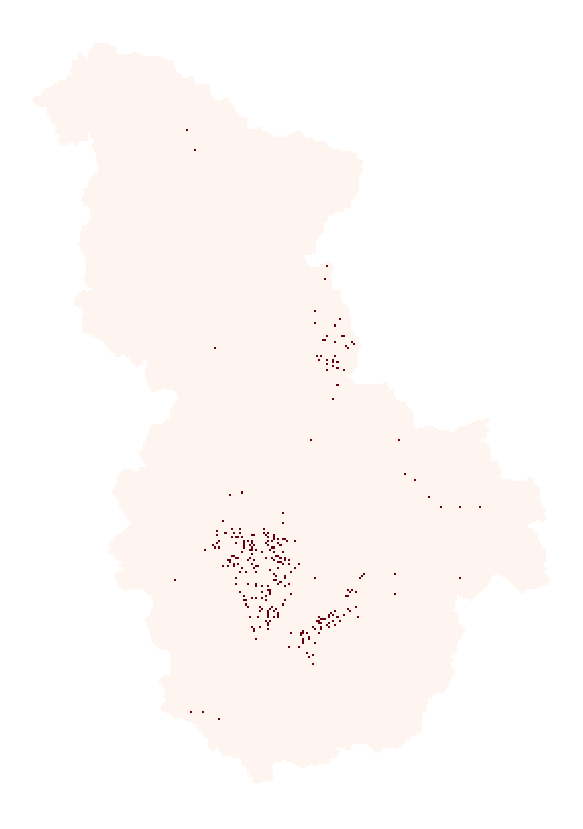

In [294]:
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white') ## 캔버스 색상 설정

material['geometry'].plot(ax=ax1, color='gainsboro')
material.plot(ax=ax1, column='EV', cmap='Reds')
ax1.set_axis_off()
plt.show()

#### 격자 중심점의 위도/경도 찾기

In [295]:
#### polygon 데이터를 슬라이싱하기 위해 string으로 변환
polygon = material['geometry'].astype('string')
polygon[0]

'POLYGON ((977800 1828600, 977800 1828700, 977900 1828700, 977900 1828600, 977800 1828600))'

In [296]:
#int(polygon[0].split()[1][2:]) + 50
int(polygon[0].split()[2][:-1]) + 50

1828650

In [297]:
loc = []

# 한 격자당 위도 변화
length_100m = (36.73376199366808 - 36.40675835257603) / 364

# 한 격자당 경도 변화
width_100m = (127.4092754044858 - 127.12765872447403) / 254

for i, P in enumerate(polygon):
    lat = (int(P.split()[2][:-1]) + 50 - 1823200) / 100 * length_100m + 36.40675835257603
    long = (int(P.split()[1][2:]) + 50 - 966700) / 100 * width_100m + 127.12765872447403
    
    loc.append((lat, long))
    
loc[:3]

[(36.4557190625747, 127.25128179463668),
 (36.53387652624231, 127.38765522629592),
 (36.585083140369356, 127.28232615306317)]

#### 중심점을 GCS 열로 생성

In [298]:
material['GCS'] = loc
material.head(3)

인구수  건축물수  EV                                           geometry  \
0   0.0   1.0   0  POLYGON ((977800.00000 1828600.00000, 977800.0...   
1   0.0   1.0   0  POLYGON ((990100.00000 1837300.00000, 990100.0...   
2  27.0   4.0   0  POLYGON ((980600.00000 1843000.00000, 980600.0...   

                                        GCS  
0    (36.4557190625747, 127.25128179463668)  
1   (36.53387652624231, 127.38765522629592)  
2  (36.585083140369356, 127.28232615306317)

In [49]:
lat=[]
lng=[]
for l in loc:
    lat.append(l[0])
    lng.append(l[1])

In [50]:
m = folium.Map(location=(36.57026017312205, 127.26846706447992), zoom_start=11)
    
heatMap = HeatMap(zip(lat, lng, material['인구수']),
                min_opacity=0.1,
                max_val=5,
                radius=5, blur=5,
                max_zoom=10,color='red')

m.add_child(heatMap)
m

In [51]:
m = folium.Map(location=(36.57026017312205, 127.26846706447992), zoom_start=11)
    
heatMap = HeatMap(zip(lat, lng, material['건축물수']),
                min_opacity=0.1,
                max_val=5,
                radius=4, blur=3,
                max_zoom=10,color='red')

m.add_child(heatMap)
m

In [52]:
m = folium.Map(location=(36.57026017312205, 127.26846706447992), zoom_start=11)
    
heatMap = HeatMap(zip(lat, lng, material['EV']),
                min_opacity=0.1,
                max_val=5,
                radius=6, blur=3,
                max_zoom=10,color='red')

m.add_child(heatMap)
m

In [65]:
material.head()

geometry   인구수  건축물수  EV
0  POLYGON ((977800.00000 1828600.00000, 977800.0...   0.0   1.0   0
1  POLYGON ((990100.00000 1837300.00000, 990100.0...   0.0   1.0   0
2  POLYGON ((980600.00000 1843000.00000, 980600.0...  27.0   4.0   0
3  POLYGON ((983800.00000 1830600.00000, 983800.0...   0.0   3.0   0
4  POLYGON ((969300.00000 1857700.00000, 969300.0...  27.0  20.0   0

### 세종시 건축물대장

In [228]:
building_reg = pd.read_csv("./dataset/전처리전/세종시_건축물대장.csv", encoding='cp949')
building_reg.head()

주용도코드명                   대지위치
0  교육연구시설    세종특별자치시  반곡동 42-9번지
1     주거지  세종특별자치시  반곡동 146-75번지
2  농축산업시설  세종특별자치시  반곡동 146-79번지
3  농축산업시설  세종특별자치시  반곡동 146-79번지
4    창고시설  세종특별자치시  반곡동 146-79번지

In [229]:
building_reg['주용도코드명'].unique()

array(['교육연구시설', '주거지', '농축산업시설', '창고시설', '편의시설', '생산시설', '자원순환관련시설',
       '자동차관련시설', '님비시설', '장례시설', '문화및집회시설'], dtype=object)

In [232]:
building_reg['주용도코드명'].value_counts()

주거지         630
편의시설        254
농축산업시설      150
창고시설        131
생산시설        129
교육연구시설       20
님비시설         18
자동차관련시설      13
자원순환관련시설     11
문화및집회시설       3
Name: 주용도코드명, dtype: int64

In [233]:
building_reg.replace({'주용도코드명' : '장례시설'}, '편의시설', inplace=True)
building_reg.replace({'주용도코드명' : '자원순환관련시설'}, '님비시설', inplace=True)
building_reg.replace({'주용도코드명' : '문화및집회시설'}, '편의시설', inplace=True)

In [234]:
building_reg['주용도코드명'].value_counts()

주거지        630
편의시설       257
농축산업시설     150
창고시설       131
생산시설       129
님비시설        29
교육연구시설      20
자동차관련시설     13
Name: 주용도코드명, dtype: int64

In [239]:
loc = []

browser = webdriver.Chrome('./dataset/chromedriver.exe')

for addr in building_reg['대지위치']:
    
    url = 'https://map.naver.com/v5/search/' + addr
    
    browser.get(url)
    time.sleep(2)
    current_url = browser.current_url
    
    browser.get('https://xn--yq5bk9r.com/blog/map-coordinates')
    elem = browser.find_element(By.XPATH, '//*[@id="__next"]/div/div/main/div[3]/article/div/div/div/div[1]/div/div[2]/div[1]/input')
    elem.send_keys(current_url + Keys.TAB + Keys.ENTER)
    time.sleep(3)
    
    try:
        location_text = browser.find_element(By.XPATH, '//*[@id="__next"]/div/div/main/div[3]/article/div/div/div/div[1]/div/div[2]/div[2]/div/div[1]').text
        
    except:
        location_text = '좌표 : 위도 : 0, 경도 : 0'

    print(location_text)    
    loc.append((location_text.split()[4][:-1], location_text.split()[-1]))

browser.quit()

좌표 : 위도 : 36.495755700000075, 경도 : 127.31101820000015
좌표 : 위도 : 36.487226300000124, 경도 : 127.31749639999963
좌표 : 위도 : 36.48822740000026, 경도 : 127.31797419999964
좌표 : 위도 : 36.48822740000026, 경도 : 127.31797419999964
좌표 : 위도 : 36.48822740000026, 경도 : 127.31797419999964
좌표 : 위도 : 36.49440309999977, 경도 : 127.31385349999972
좌표 : 위도 : 36.4825272000002, 경도 : 127.3106030999995
좌표 : 위도 : 36.48244349999957, 경도 : 127.31094959999987
좌표 : 위도 : 36.480665399999715, 경도 : 127.31372759999965
좌표 : 위도 : 36.480238899999584, 경도 : 127.31224970000004
좌표 : 위도 : 36.47888089999957, 경도 : 127.3041550999998
좌표 : 위도 : 36.479295200000095, 경도 : 127.30327269999961
좌표 : 위도 : 36.47915190000007, 경도 : 127.30342389999952
좌표 : 위도 : 36.47901849999966, 경도 : 127.30369629999959
좌표 : 위도 : 36.47901849999966, 경도 : 127.30369629999959
좌표 : 위도 : 36.483433799999766, 경도 : 127.30058430000004
좌표 : 위도 : 36.48353730000011, 경도 : 127.30005589999945
좌표 : 위도 : 36.484638300000206, 경도 : 127.30480709999983
좌표 : 위도 : 36.484638300000206, 경도 : 127.304

좌표 : 위도 : 36.52415710000021, 경도 : 127.27724139999948
좌표 : 위도 : 36.52385229999978, 경도 : 127.27769259999997
좌표 : 위도 : 36.52602420000016, 경도 : 127.2761673999996
좌표 : 위도 : 36.52602420000016, 경도 : 127.2761673999996
좌표 : 위도 : 36.52641560000004, 경도 : 127.27713839999994
좌표 : 위도 : 36.53117309999968, 경도 : 127.33156359999975
좌표 : 위도 : 36.5274297999999, 경도 : 127.33349409999997
좌표 : 위도 : 36.52698509999954, 경도 : 127.33394740000017
좌표 : 위도 : 36.52760889999989, 경도 : 127.33316500000014
좌표 : 위도 : 36.52777529999994, 경도 : 127.33152639999938
좌표 : 위도 : 36.52645859999975, 경도 : 127.33090649999974
좌표 : 위도 : 36.52587799999982, 경도 : 127.33180469999948
좌표 : 위도 : 36.52587799999982, 경도 : 127.33180469999948
좌표 : 위도 : 36.52587799999982, 경도 : 127.33180469999948
좌표 : 위도 : 36.52587799999982, 경도 : 127.33180469999948
좌표 : 위도 : 36.50560159999995, 경도 : 127.3150334999994
좌표 : 위도 : 36.50560159999995, 경도 : 127.3150334999994
좌표 : 위도 : 36.50560159999995, 경도 : 127.3150334999994
좌표 : 위도 : 36.50560159999995, 경도 : 127.3150334999994


좌표 : 위도 : 36.60772670000009, 경도 : 127.29737620000014
좌표 : 위도 : 36.60762480000007, 경도 : 127.29707249999976
좌표 : 위도 : 36.60762480000007, 경도 : 127.29707249999976
좌표 : 위도 : 36.6080494000001, 경도 : 127.29758009999951
좌표 : 위도 : 36.60856910000007, 경도 : 127.29701199999968
좌표 : 위도 : 36.60856910000007, 경도 : 127.29701199999968
좌표 : 위도 : 36.608267099999765, 경도 : 127.29705879999997
좌표 : 위도 : 36.60903209999997, 경도 : 127.2968002999997
좌표 : 위도 : 36.60903209999997, 경도 : 127.2968002999997
좌표 : 위도 : 36.548420300000195, 경도 : 127.28071260000003
좌표 : 위도 : 36.547681700000226, 경도 : 127.28057569999991
좌표 : 위도 : 36.54754709999982, 경도 : 127.28057069999949
좌표 : 위도 : 36.54741369999992, 경도 : 127.2805653999995
좌표 : 위도 : 36.547277799999776, 경도 : 127.2805593999999
좌표 : 위도 : 36.5482948999996, 경도 : 127.2808224000001
좌표 : 위도 : 36.548049200000094, 경도 : 127.28081789999929
좌표 : 위도 : 36.54765150000023, 경도 : 127.28084599999937
좌표 : 위도 : 36.547526700000155, 경도 : 127.28084239999998
좌표 : 위도 : 36.547400200000155, 경도 : 127.28083870

좌표 : 위도 : 36.567832900000084, 경도 : 127.37663969999933
좌표 : 위도 : 36.5662816000002, 경도 : 127.37502739999938
좌표 : 위도 : 36.5662816000002, 경도 : 127.37502739999938
좌표 : 위도 : 36.564102099999666, 경도 : 127.36755340000018
좌표 : 위도 : 36.56263519999998, 경도 : 127.3608769
좌표 : 위도 : 36.56245969999983, 경도 : 127.36124319999931
좌표 : 위도 : 36.56200119999977, 경도 : 127.36126559999938
좌표 : 위도 : 36.56150799999997, 경도 : 127.36064380000005
좌표 : 위도 : 36.56150799999997, 경도 : 127.36064380000005
좌표 : 위도 : 36.56150799999997, 경도 : 127.36064380000005
좌표 : 위도 : 36.5624793000003, 경도 : 127.36101629999987
좌표 : 위도 : 36.56086209999964, 경도 : 127.36025609999986
좌표 : 위도 : 36.56086209999964, 경도 : 127.36025609999986
좌표 : 위도 : 36.56086209999964, 경도 : 127.36025609999986
좌표 : 위도 : 36.54177080000022, 경도 : 127.3477192000001
좌표 : 위도 : 36.54825349999976, 경도 : 127.36904679999974
좌표 : 위도 : 36.54825349999976, 경도 : 127.36904679999974
좌표 : 위도 : 36.54743510000006, 경도 : 127.3688097999999
좌표 : 위도 : 36.54743510000006, 경도 : 127.3688097999999
좌표 :

좌표 : 위도 : 36.48124579999977, 경도 : 127.33204779999937
좌표 : 위도 : 36.48124579999977, 경도 : 127.33204779999937
좌표 : 위도 : 36.48124579999977, 경도 : 127.33204779999937
좌표 : 위도 : 36.48124579999977, 경도 : 127.33204779999937
좌표 : 위도 : 36.48124579999977, 경도 : 127.33204779999937
좌표 : 위도 : 36.48047459999976, 경도 : 127.3303307999993
좌표 : 위도 : 36.48047459999976, 경도 : 127.3303307999993
좌표 : 위도 : 36.48047459999976, 경도 : 127.3303307999993
좌표 : 위도 : 36.48047459999976, 경도 : 127.3303307999993
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 36.4720437999999, 경도 : 127.33412490000002
좌표 : 위도 : 36.47515949999998, 경도 : 127.33517109999941
좌표 : 위도 : 36.47442940000007, 경도 : 127.34130929999954
좌표 : 위도 : 37.4040625999996, 경도 : 126.94139119999966
좌표 : 위도 : 36.470326299999755, 경도 : 127.33420329999933
좌표 : 위도 : 36.470326299999755, 경도 : 127.33420329999933
좌표 : 위도 : 36.470326299999755, 경도 : 127.33420329999933
좌표 : 위도 : 36.46991279999985, 경도 : 127.32944689999941
좌표 : 위도 : 36.46981199999973, 경도 : 127.330108399999

좌표 : 위도 : 36.444696800000116, 경도 : 127.24671339999982
좌표 : 위도 : 36.44502500000027, 경도 : 127.24638779999984
좌표 : 위도 : 36.44497450000009, 경도 : 127.24706289999953
좌표 : 위도 : 36.44475630000023, 경도 : 127.24706959999965
좌표 : 위도 : 36.43710670000013, 경도 : 127.24220759999996
좌표 : 위도 : 36.437024799999705, 경도 : 127.24242289999935
좌표 : 위도 : 36.43775930000001, 경도 : 127.24022120000005
좌표 : 위도 : 36.43775930000001, 경도 : 127.24022120000005
좌표 : 위도 : 36.437502799999635, 경도 : 127.24060019999997
좌표 : 위도 : 36.437502799999635, 경도 : 127.24060019999997
좌표 : 위도 : 36.43833550000009, 경도 : 127.23972929999935
좌표 : 위도 : 36.43833550000009, 경도 : 127.23972929999935
좌표 : 위도 : 36.43777680000019, 경도 : 127.24057490000014
좌표 : 위도 : 36.43747519999997, 경도 : 127.23376459999967
좌표 : 위도 : 36.499006499999616, 경도 : 127.20799779999942
좌표 : 위도 : 36.49872040000001, 경도 : 127.20774949999999
좌표 : 위도 : 36.49880069999981, 경도 : 127.20789439999986
좌표 : 위도 : 36.49776709999996, 경도 : 127.20647460000012
좌표 : 위도 : 36.49776709999996, 경도 : 127.206

좌표 : 위도 : 36.57527379999987, 경도 : 127.2973353999995
좌표 : 위도 : 36.575254099999974, 경도 : 127.29712959999952
좌표 : 위도 : 36.57535999999973, 경도 : 127.2967144999998
좌표 : 위도 : 36.57520689999994, 경도 : 127.29657269999973
좌표 : 위도 : 36.574876099999564, 경도 : 127.29700159999973
좌표 : 위도 : 36.574876099999564, 경도 : 127.29700159999973
좌표 : 위도 : 36.574876099999564, 경도 : 127.29700159999973
좌표 : 위도 : 36.57224559999979, 경도 : 127.28358049999959
좌표 : 위도 : 36.5719775, 경도 : 127.28498419999937
좌표 : 위도 : 36.572583300000275, 경도 : 127.28236380000004
좌표 : 위도 : 36.572583300000275, 경도 : 127.28236380000004
좌표 : 위도 : 36.572583300000275, 경도 : 127.28236380000004
좌표 : 위도 : 36.572583300000275, 경도 : 127.28236380000004
좌표 : 위도 : 36.572583300000275, 경도 : 127.28236380000004
좌표 : 위도 : 36.57633059999965, 경도 : 127.2793636999994
좌표 : 위도 : 36.57642100000012, 경도 : 127.28064199999956
좌표 : 위도 : 36.5768565999998, 경도 : 127.27989959999923
좌표 : 위도 : 36.5949426000001, 경도 : 127.25152350000013
좌표 : 위도 : 36.5922618999997, 경도 : 127.254269399999

좌표 : 위도 : 36.703061599999984, 경도 : 127.19192609999926
좌표 : 위도 : 36.676919899999604, 경도 : 127.19884909999959
좌표 : 위도 : 36.66830769999979, 경도 : 127.18193740000004
좌표 : 위도 : 36.67661419999999, 경도 : 127.19789839999959
좌표 : 위도 : 36.67661419999999, 경도 : 127.19789839999959
좌표 : 위도 : 36.676542899999575, 경도 : 127.1978160999995
좌표 : 위도 : 36.676542899999575, 경도 : 127.1978160999995
좌표 : 위도 : 36.67647069999975, 경도 : 127.19761089999959
좌표 : 위도 : 36.67649999999999, 경도 : 127.19704789999976
좌표 : 위도 : 36.67638920000015, 경도 : 127.1972929999998
좌표 : 위도 : 36.6754190000001, 경도 : 127.19879289999946
좌표 : 위도 : 36.66994140000021, 경도 : 127.19456679999982
좌표 : 위도 : 36.66994140000021, 경도 : 127.19456679999982
좌표 : 위도 : 36.67099699999996, 경도 : 127.19388939999949
좌표 : 위도 : 36.668985599999615, 경도 : 127.19262349999944
좌표 : 위도 : 36.669357100000184, 경도 : 127.19205730000022
좌표 : 위도 : 36.668257899999965, 경도 : 127.1902919999993
좌표 : 위도 : 36.66816139999966, 경도 : 127.1905278999995
좌표 : 위도 : 36.668017700000014, 경도 : 127.190563

좌표 : 위도 : 36.658383199999705, 경도 : 127.25234489999978
좌표 : 위도 : 36.6533097999998, 경도 : 127.25925020000003
좌표 : 위도 : 36.653321799999986, 경도 : 127.25894680000009
좌표 : 위도 : 36.6530426, 경도 : 127.25867299999989
좌표 : 위도 : 36.6530426, 경도 : 127.25867299999989
좌표 : 위도 : 36.65399350000028, 경도 : 127.25919219999973
좌표 : 위도 : 36.646661400000085, 경도 : 127.26505180000015
좌표 : 위도 : 36.646608899999606, 경도 : 127.2661670999994
좌표 : 위도 : 36.646608899999606, 경도 : 127.2661670999994
좌표 : 위도 : 36.64677519999971, 경도 : 127.26613869999974
좌표 : 위도 : 36.64677519999971, 경도 : 127.26613869999974
좌표 : 위도 : 36.64699680000016, 경도 : 127.26866919999928
좌표 : 위도 : 36.64714709999992, 경도 : 127.27098100000003
좌표 : 위도 : 36.64700379999976, 경도 : 127.27091209999931
좌표 : 위도 : 36.639082200000175, 경도 : 127.27002909999993
좌표 : 위도 : 36.63845859999967, 경도 : 127.26994410000007
좌표 : 위도 : 36.63173479999976, 경도 : 127.27625639999977
좌표 : 위도 : 36.63231700000026, 경도 : 127.27633349999941
좌표 : 위도 : 36.631308699999785, 경도 : 127.27655309999959
좌표 

In [253]:
building_reg['GCS'] = loc
building_reg.head(5)

주용도코드명                   대지위치                                       GCS
0  교육연구시설    세종특별자치시  반곡동 42-9번지  (36.495755700000075, 127.31101820000015)
1     주거지  세종특별자치시  반곡동 146-75번지  (36.487226300000124, 127.31749639999963)
2  농축산업시설  세종특별자치시  반곡동 146-79번지   (36.48822740000026, 127.31797419999964)
3  농축산업시설  세종특별자치시  반곡동 146-79번지   (36.48822740000026, 127.31797419999964)
4    창고시설  세종특별자치시  반곡동 146-79번지   (36.48822740000026, 127.31797419999964)

#### 위치를 수집하지 못한 주소가 존재함

In [255]:
building_reg[(building_reg['GCS']==('0', '0')) | (building_reg['GCS']==('37.4040625999996', '126.94139119999966'))]

주용도코드명                      대지위치                                     GCS
124     주거지        세종특별자치시  아름동 592번지  (37.4040625999996, 126.94139119999966)
146    창고시설      세종특별자치시  산울동 221-1번지  (37.4040625999996, 126.94139119999966)
380     주거지  세종특별자치시  연동면 명학리 44-41번지  (37.4040625999996, 126.94139119999966)
390     주거지  세종특별자치시  연동면 명학리 44-41번지  (37.4040625999996, 126.94139119999966)
534    편의시설  세종특별자치시  금남면 용포리 22-14번지  (37.4040625999996, 126.94139119999966)
630     주거지   세종특별자치시  금남면 영대리 38-1번지  (37.4040625999996, 126.94139119999966)
634     주거지  세종특별자치시  금남면 영대리 137-1번지  (37.4040625999996, 126.94139119999966)
688     주거지  세종특별자치시  금남면 장재리 117-3번지  (37.4040625999996, 126.94139119999966)
825    창고시설    세종특별자치시  장군면 봉안리 2-1번지                                  (0, 0)
826  농축산업시설    세종특별자치시  장군면 봉안리 2-1번지                                  (0, 0)
880     주거지   세종특별자치시  장군면 송정리 24-9번지  (37.4040625999996, 126.94139119999966)
882     주거지   세종특별자치시  장군면 송정리 38-4번지  (37.4040625999996, 126.94139119999966)
887    편의시설   세종특별자치시  장군면 송정리 96-7번지  (37.4040625999996, 126.94139119999966)

In [256]:
building_reg['GCS'].loc[124] = ('36.48942059999998', '127.24274109999963')
building_reg['GCS'].loc[146] = ('36.53569029999984', '127.26223069999995')
building_reg['GCS'].loc[380] = ('36.53537079999972', '127.34658059999936')
building_reg['GCS'].loc[390] = ('36.53537079999972', '127.34658059999936')
building_reg['GCS'].loc[534] = ('36.46527889999958', '127.28584779999981')
building_reg['GCS'].loc[630] = ('36.45643329999962', '127.33668870000007')
building_reg['GCS'].loc[634] = ('36.45439270000004', '127.32350469999933')
building_reg['GCS'].loc[688] = ('36.47860450000016', '127.31325520000011')
building_reg['GCS'].loc[825] = ('36.4772391042593', '127.24035512980936')
building_reg['GCS'].loc[826] = ('36.4772391042593', '127.24035512980936')
building_reg['GCS'].loc[880] = ('36.507206999999575', '127.18714550000003')
building_reg['GCS'].loc[882] = ('36.50395569999959', '127.17566009999966')
building_reg['GCS'].loc[887] = ('36.504110499999661', '27.17381179999994')

In [257]:
building_reg[(building_reg['GCS']==('0', '0')) | (building_reg['GCS']==('37.4040625999996', '126.94139119999966'))]

Empty DataFrame
Columns: [주용도코드명, 대지위치, GCS]
Index: []

#### 세종시를 벗어난 좌표가 있는지 확인

In [266]:
for gcs in building_reg['GCS']:
    if float(gcs[0]) < 36.40675835257603 and float(gcs[0]) > 36.73376199366808:
        print(gcs)
    if float(gcs[1]) < 127.12765872447403 and float(gcs[1]) > 127.4092754044858:
        print(gcs)

#### 위도/경도를 폴리곤 좌표로 치환

In [268]:
poly = []

# 한 격자당 위도 변화
length_100m = (36.73376199366808 - 36.40675835257603) / 364

# 한 격자당 경도 변화
width_100m = (127.4092754044858 - 127.12765872447403) / 254

for i, GCS in enumerate(building_reg['GCS']):
    poly_x = 966700 + (float(GCS[1]) - 127.12765872447403)/width_100m * 100
    poly_y = 1823200 + (float(GCS[0]) - 36.40675835257603)/length_100m * 100
    #print('(', GCS.split()[0][2:-2] + ",", GCS.split()[1][1:-2], ')', end=('→'))
    #print('(', poly_y, ",", poly_x, ')')
    poly.append((poly_x, poly_y))

In [270]:
building_reg['POLYGON'] = poly
building_reg.head()

주용도코드명                   대지위치                                       GCS  \
0  교육연구시설    세종특별자치시  반곡동 42-9번지  (36.495755700000075, 127.31101820000015)   
1     주거지  세종특별자치시  반곡동 146-75번지  (36.487226300000124, 127.31749639999963)   
2  농축산업시설  세종특별자치시  반곡동 146-79번지   (36.48822740000026, 127.31797419999964)   
3  농축산업시설  세종특별자치시  반곡동 146-79번지   (36.48822740000026, 127.31797419999964)   
4    창고시설  세종특별자치시  반곡동 146-79번지   (36.48822740000026, 127.31797419999964)   

                                   POLYGON  
0  (983237.8367437923, 1833106.6280589928)  
1  (983822.1284128081, 1832157.1886002717)  
2   (983865.2228772404, 1832268.624790656)  
3   (983865.2228772404, 1832268.624790656)  
4   (983865.2228772404, 1832268.624790656)

#### 중복된 주소가 있으므로 원핫인코딩이 불가

In [285]:
building_reg[building_reg['대지위치'].duplicated()].head()

주용도코드명                   대지위치                                       GCS  \
3   농축산업시설  세종특별자치시  반곡동 146-79번지   (36.48822740000026, 127.31797419999964)   
4     창고시설  세종특별자치시  반곡동 146-79번지   (36.48822740000026, 127.31797419999964)   
14    편의시설    세종특별자치시  소담동 9-66번지   (36.47901849999966, 127.30369629999959)   
19    생산시설      세종특별자치시  소담동 11번지  (36.484638300000206, 127.30480709999983)   
21    편의시설      세종특별자치시  보람동 40번지   (36.47769929999982, 127.29749119999978)   

                                    POLYGON  
3    (983865.2228772404, 1832268.624790656)  
4    (983865.2228772404, 1832268.624790656)  
14   (982577.4488008391, 1831243.547641966)  
19  (982677.6357642147, 1831869.1086275766)  
21  (982017.7889824348, 1831096.7025492513)

In [309]:
building_reg['주용도코드명'].unique()

array(['교육연구시설', '주거지', '농축산업시설', '창고시설', '편의시설', '생산시설', '님비시설',
       '자동차관련시설'], dtype=object)

In [307]:
building_reg['주용도코드명'].value_counts()

주거지        630
편의시설       257
농축산업시설     150
창고시설       131
생산시설       129
님비시설        29
교육연구시설      20
자동차관련시설     13
Name: 주용도코드명, dtype: int64

#### 위치별 딕셔너리를 생성해서 주용도별로 분류 후, 리스트에 정리

In [318]:
reg = []

for i in building_reg.drop_duplicates(['POLYGON']).index:
    dic = {'교육연구시설':0, '주거지':0, '농축산업시설':0, '창고시설':0, '편의시설':0, '생산시설':0, '님비시설':0,
       '자동차관련시설':0}
    temp = building_reg[building_reg['POLYGON']==building_reg['POLYGON'].loc[i]]
    for j in range(len(temp['주용도코드명'].unique())):
        dic[temp['주용도코드명'].unique()[j]] = temp['주용도코드명'].value_counts()[j]
    reg.append(dic)

In [319]:
reg[:2]

[{'교육연구시설': 1,
  '주거지': 0,
  '농축산업시설': 0,
  '창고시설': 0,
  '편의시설': 0,
  '생산시설': 0,
  '님비시설': 0,
  '자동차관련시설': 0},
 {'교육연구시설': 0,
  '주거지': 1,
  '농축산업시설': 0,
  '창고시설': 0,
  '편의시설': 0,
  '생산시설': 0,
  '님비시설': 0,
  '자동차관련시설': 0}]

#### 중복을 제거한 폴리곤 좌표

In [322]:
building_reg_p = building_reg[['POLYGON']].drop_duplicates(['POLYGON'])
building_reg_p.head()

POLYGON
0  (983237.8367437923, 1833106.6280589928)
1  (983822.1284128081, 1832157.1886002717)
2   (983865.2228772404, 1832268.624790656)
5  (983493.5624344232, 1832956.0650871354)
6  (983200.3974130818, 1831634.1141799807)

#### 주용도별로 열 생성

In [329]:
for n in building_reg['주용도코드명'].unique():
    temp = []
    for r in reg:
        temp.append(r[n])
    building_reg_p[n] = temp

building_reg_p.head()

POLYGON  교육연구시설  주거지  농축산업시설  창고시설  편의시설  \
0  (983237.8367437923, 1833106.6280589928)       1    0       0     0     0   
1  (983822.1284128081, 1832157.1886002717)       0    1       0     0     0   
2   (983865.2228772404, 1832268.624790656)       0    0       2     1     0   
5  (983493.5624344232, 1832956.0650871354)       1    0       0     0     0   
6  (983200.3974130818, 1831634.1141799807)       0    1       0     0     0   

   생산시설  님비시설  자동차관련시설  
0     0     0        0  
1     0     0        0  
2     0     0        0  
5     0     0        0  
6     0     0        0

In [343]:
building_reg_p.reset_index(drop=False, inplace=True)

#### 데이터 병합

In [339]:
geometry = material.geometry.copy().astype('string')

In [355]:
for r in building_reg['주용도코드명'].unique():
    temp = []
    for g in geometry:
        g = g.split()
        # print(g[1][2:], g[2][:-1], g[4][:-1], g[5]) # 폴리곤의 좌측x, 하단y, 상단y, 우측x 좌표
        cnt = 0
        
        for i, p in enumerate(building_reg_p.POLYGON):
            x = int(float(p[0]))
            y = int(float(p[1]))

            if x>int(g[1][2:]) and x<int(g[5]) and y>int(g[2][:-1]) and y<int(g[4][:-1]):
                cnt += building_reg_p.iloc[i][r]

        temp.append(cnt)
    material[r] = temp

material.head()

인구수  건축물수  EV                                           geometry  교육연구시설  \
0   0.0   1.0   0  POLYGON ((977800.00000 1828600.00000, 977800.0...       0   
1   0.0   1.0   0  POLYGON ((990100.00000 1837300.00000, 990100.0...       0   
2  27.0   4.0   0  POLYGON ((980600.00000 1843000.00000, 980600.0...       0   
3   0.0   3.0   0  POLYGON ((983800.00000 1830600.00000, 983800.0...       0   
4  27.0  20.0   0  POLYGON ((969300.00000 1857700.00000, 969300.0...       0   

   주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  
0    0       0     0     0     0     0        0  
1    0       0     0     0     0     0        0  
2    0       0     0     0     0     0        0  
3    0       0     0     0     0     0        0  
4    0       0     0     0     0     0        0

In [55]:
#### 데이터 재정렬
material = material[['geometry', '인구수', '건축물수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

material.head(5)

geometry  인구수  건축물수  교육연구시설  주거지  \
0  POLYGON ((977800.00000 1828600.00000, 977800.0...    0     1       0    0   
1  POLYGON ((990100.00000 1837300.00000, 990100.0...    0     1       0    0   
2  POLYGON ((980600.00000 1843000.00000, 980600.0...   27     4       0    0   
3  POLYGON ((983800.00000 1830600.00000, 983800.0...    0     3       0    0   
4  POLYGON ((969300.00000 1857700.00000, 969300.0...   27    20       0    0   

   농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  
0       0     0     0     0     0        0   0  
1       0     0     0     0     0        0   0  
2       0     0     0     0     0        0   0  
3       0     0     0     0     0        0   0  
4       0     0     0     0     0        0   0

In [56]:
material.to_file('./dataset/전처리후/merge_3.geojson', driver='GeoJSON')

In [3]:
material = geopandas.read_file('./dataset/전처리후/merge_3.geojson', encoding='utf-8')
material = material[['geometry', '인구수', '건축물수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]
material.head()

geometry  인구수  건축물수  교육연구시설  주거지  \
0  POLYGON ((977800.00000 1828600.00000, 977800.0...    0     1       0    0   
1  POLYGON ((990100.00000 1837300.00000, 990100.0...    0     1       0    0   
2  POLYGON ((980600.00000 1843000.00000, 980600.0...   27     4       0    0   
3  POLYGON ((983800.00000 1830600.00000, 983800.0...    0     3       0    0   
4  POLYGON ((969300.00000 1857700.00000, 969300.0...   27    20       0    0   

   농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  
0       0     0     0     0     0        0   0  
1       0     0     0     0     0        0   0  
2       0     0     0     0     0        0   0  
3       0     0     0     0     0        0   0  
4       0     0     0     0     0        0   0

### 세종시 주차장 위치

In [4]:
parking_loc = pd.read_csv("./dataset/전처리전/세종시_주차장_위치.csv", encoding='cp949')
parking_loc.head()

주차장명 주차장구분            소재지도로명주소               소재지지번주소  주차구획수         위도  \
0  아름주차장    민영  세종특별자치시 보듬3로 104-7    세종특별자치시 아름동 1287번지     54  36.512321   
1   원프라자    민영   세종특별자치시 보듬3로 8-37     세종특별자치시 도담동 678번지    107  36.515574   
2  도담프라자    민영    세종특별자치시 보듬3로 8-5     세종특별자치시 도담동 668번지    127  36.512822   
3  온누리타워    민영    세종특별자치시 새롬중앙로 63     세종특별자치시 새롬동 산25번지     50  36.486537   
4  무지개타워    민영    세종특별자치시 새롬중앙로 41  세종특별자치시 새롬동 341-95번지    231  36.484534   

           경도  
0  127.248429  
1  127.257844  
2  127.258317  
3  127.250254  
4  127.251234

#### 위도/경도를 폴리곤 좌표로 치환

In [5]:
poly = []

# 한 격자당 위도 변화
length_100m = (36.73376199366808 - 36.40675835257603) / 364

# 한 격자당 경도 변화
width_100m = (127.4092754044858 - 127.12765872447403) / 254

for i in range(len(parking_loc)):
    lat, long = parking_loc['위도'][i], parking_loc['경도'][i]
    poly_x = 966700 + (long - 127.12765872447403)/width_100m * 100
    poly_y = 1823200 + (lat - 36.40675835257603)/length_100m * 100
    #print('(', GCS.split()[0][2:-2] + ",", GCS.split()[1][1:-2], ')', end=('→'))
    #print('(', poly_y, ",", poly_x, ')')
    poly.append((poly_x, poly_y))

In [6]:
parking_loc['POLYGON'] = poly
parking_loc.head()

주차장명 주차장구분            소재지도로명주소               소재지지번주소  주차구획수         위도  \
0  아름주차장    민영  세종특별자치시 보듬3로 104-7    세종특별자치시 아름동 1287번지     54  36.512321   
1   원프라자    민영   세종특별자치시 보듬3로 8-37     세종특별자치시 도담동 678번지    107  36.515574   
2  도담프라자    민영    세종특별자치시 보듬3로 8-5     세종특별자치시 도담동 668번지    127  36.512822   
3  온누리타워    민영    세종특별자치시 새롬중앙로 63     세종특별자치시 새롬동 산25번지     50  36.486537   
4  무지개타워    민영    세종특별자치시 새롬중앙로 41  세종특별자치시 새롬동 341-95번지    231  36.484534   

           경도                                  POLYGON  
0  127.248429  (977592.6964064469, 1834950.5736431568)  
1  127.257844  (978441.8684085815, 1835312.6772564517)  
2  127.258317  (978484.5299441109, 1835006.3418295265)  
3  127.250254   (977757.2635052346, 1832080.431094084)  
4  127.251234   (977845.6621753671, 1831857.510848436)

#### 데이터 병합

In [7]:
geometry = material.geometry.copy().astype('string')

s = []
c = []

for g in geometry:
    g = g.split()
    # print(g[1][2:], g[2][:-1], g[4][:-1], g[5]) # 폴리곤의 좌측x, 하단y, 상단y, 우측x 좌표
    section = 0
    cnt = 0

    for i, p in enumerate(parking_loc.POLYGON):
        x = int(float(p[0]))
        y = int(float(p[1]))

        if x>int(g[1][2:]) and x<int(g[5]) and y>int(g[2][:-1]) and y<int(g[4][:-1]):
            section += parking_loc.iloc[i]['주차구획수']
            cnt += 1
            
    s.append(section)
    c.append(cnt)

material['주차장수'] = c
material['주차구획수'] = s

material = material[['geometry', '인구수', '건축물수', '주차장수', '주차구획수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]
material.head()

geometry  인구수  건축물수  주차장수  주차구획수  \
0  POLYGON ((977800.00000 1828600.00000, 977800.0...    0     1     0      0   
1  POLYGON ((990100.00000 1837300.00000, 990100.0...    0     1     0      0   
2  POLYGON ((980600.00000 1843000.00000, 980600.0...   27     4     0      0   
3  POLYGON ((983800.00000 1830600.00000, 983800.0...    0     3     0      0   
4  POLYGON ((969300.00000 1857700.00000, 969300.0...   27    20     0      0   

   교육연구시설  주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  
0       0    0       0     0     0     0     0        0   0  
1       0    0       0     0     0     0     0        0   0  
2       0    0       0     0     0     0     0        0   0  
3       0    0       0     0     0     0     0        0   0  
4       0    0       0     0     0     0     0        0   0

In [8]:
material.to_file('./dataset/전처리후/merge_4.geojson', driver='GeoJSON')

In [9]:
material = geopandas.read_file('./dataset/전처리후/merge_4.geojson', encoding='utf-8')
material = material[['geometry', '인구수', '건축물수', '주차장수', '주차구획수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]
material.head()

geometry  인구수  건축물수  주차장수  주차구획수  \
0  POLYGON ((977800.00000 1828600.00000, 977800.0...    0     1     0      0   
1  POLYGON ((990100.00000 1837300.00000, 990100.0...    0     1     0      0   
2  POLYGON ((980600.00000 1843000.00000, 980600.0...   27     4     0      0   
3  POLYGON ((983800.00000 1830600.00000, 983800.0...    0     3     0      0   
4  POLYGON ((969300.00000 1857700.00000, 969300.0...   27    20     0      0   

   교육연구시설  주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  
0       0    0       0     0     0     0     0        0   0  
1       0    0       0     0     0     0     0        0   0  
2       0    0       0     0     0     0     0        0   0  
3       0    0       0     0     0     0     0        0   0  
4       0    0       0     0     0     0     0        0   0

### 세종시 주유소 현황

In [10]:
gas_station = pd.read_csv('./dataset/전처리전/세종시_주유소_현황.csv', encoding='cp949')
gas_station.head()

상호                     주소         위도          경도
0            세종동부농협주유소   세종특별자치시 부강면 부강외천로 10  36.671429  127.217462
1  ㈜선인상사 우리나라주유소(명칭변경)  세종특별자치시 전의면 운주산로 1032  36.627999  127.289747
2               굿모닝주유소  세종특별자치시 조치원읍 세종로 2712  36.625103  127.290555
3                신안주유소  세종특별자치시 조치원읍 세종로 2678  36.731322  127.168313
4                진영주유소  세종특별자치시  소정면 세종로 4732  36.559414  127.281363

In [11]:
len(gas_station)

70

In [12]:
poly = []

# 한 격자당 위도 변화
length_100m = (36.73376199366808 - 36.40675835257603) / 364

# 한 격자당 경도 변화
width_100m = (127.4092754044858 - 127.12765872447403) / 254

for i in range(len(gas_station)):
    poly_x = 966700 + (gas_station['경도'][i] - 127.12765872447403)/width_100m * 100
    poly_y = 1823200 + (gas_station['위도'][i] - 36.40675835257603)/length_100m * 100
    #print('(', GCS.split()[0][2:-2] + ",", GCS.split()[1][1:-2], ')', end=('→'))
    #print('(', poly_y, ",", poly_x, ')')
    poly.append((poly_x, poly_y))

In [13]:
gas_station['POLYGON'] = poly
gas_station.head()

상호                     주소         위도          경도  \
0            세종동부농협주유소   세종특별자치시 부강면 부강외천로 10  36.671429  127.217462   
1  ㈜선인상사 우리나라주유소(명칭변경)  세종특별자치시 전의면 운주산로 1032  36.627999  127.289747   
2               굿모닝주유소  세종특별자치시 조치원읍 세종로 2712  36.625103  127.290555   
3                신안주유소  세종특별자치시 조치원읍 세종로 2678  36.731322  127.168313   
4                진영주유소  세종특별자치시  소정면 세종로 4732  36.559414  127.281363   

                                  POLYGON  
0  (974799.6375579179, 1852661.517755763)  
1  (981319.3213348996, 1847827.171817838)  
2  (981392.1526032711, 1847504.761572961)  
3  (970366.7793197345, 1859328.407410934)  
4  (980563.1478724787, 1840192.656264241)

In [14]:
geometry = material.geometry.copy().astype('string')

c = []

for g in geometry:
    g = g.split()
    # print(g[1][2:], g[2][:-1], g[4][:-1], g[5]) # 폴리곤의 좌측x, 하단y, 상단y, 우측x 좌표
    cnt = 0

    for i, p in enumerate(gas_station.POLYGON):
        x = int(float(p[0]))
        y = int(float(p[1]))

        if x>int(g[1][2:]) and x<int(g[5]) and y>int(g[2][:-1]) and y<int(g[4][:-1]):
            cnt += 1

    c.append(cnt)

material['주유소'] = c

material = material[['geometry', '인구수', '건축물수', '주차장수', '주유소', '주차구획수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]
material.head()

geometry  인구수  건축물수  주차장수  주유소  \
0  POLYGON ((977800.00000 1828600.00000, 977800.0...    0     1     0    0   
1  POLYGON ((990100.00000 1837300.00000, 990100.0...    0     1     0    0   
2  POLYGON ((980600.00000 1843000.00000, 980600.0...   27     4     0    0   
3  POLYGON ((983800.00000 1830600.00000, 983800.0...    0     3     0    0   
4  POLYGON ((969300.00000 1857700.00000, 969300.0...   27    20     0    0   

   주차구획수  교육연구시설  주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  
0      0       0    0       0     0     0     0     0        0   0  
1      0       0    0       0     0     0     0     0        0   0  
2      0       0    0       0     0     0     0     0        0   0  
3      0       0    0       0     0     0     0     0        0   0  
4      0       0    0       0     0     0     0     0        0   0

In [15]:
material.to_file('./dataset/전처리후/merge_5.geojson', driver='GeoJSON')

In [16]:
material = geopandas.read_file('./dataset/전처리후/merge_5.geojson', encoding='utf-8')
material = material[['geometry', '인구수', '건축물수', '주차장수', '주유소', '주차구획수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

material.head()

geometry  인구수  건축물수  주차장수  주유소  \
0  POLYGON ((977800.00000 1828600.00000, 977800.0...    0     1     0    0   
1  POLYGON ((990100.00000 1837300.00000, 990100.0...    0     1     0    0   
2  POLYGON ((980600.00000 1843000.00000, 980600.0...   27     4     0    0   
3  POLYGON ((983800.00000 1830600.00000, 983800.0...    0     3     0    0   
4  POLYGON ((969300.00000 1857700.00000, 969300.0...   27    20     0    0   

   주차구획수  교육연구시설  주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  
0      0       0    0       0     0     0     0     0        0   0  
1      0       0    0       0     0     0     0     0        0   0  
2      0       0    0       0     0     0     0     0        0   0  
3      0       0    0       0     0     0     0     0        0   0  
4      0       0    0       0     0     0     0     0        0   0

#### VDS_도로별_교통량_연평균_점유율

In [17]:
VDS_traffic = pd.read_csv("./dataset/전처리전/VDS_위치별_연평균점유율.csv", encoding='cp949')
VDS_traffic.head()

도로명       위치      mean         위도          경도
0   갈매로    기쁨뜰공원  3.039768  36.520159  127.254002
1   갈매로    제3주차장  2.926606  36.540225  127.250673
2   당산로  연서면 봉암리  3.426925  36.558723  127.252664
3  산학리길  장군면 산학리  2.915330  36.481901  127.195338
4   새내로   서울외과 앞  5.015715  36.598064  127.290457

In [18]:
poly = []

# 한 격자당 위도 변화
length_100m = (36.73376199366808 - 36.40675835257603) / 364

# 한 격자당 경도 변화
width_100m = (127.4092754044858 - 127.12765872447403) / 254

for i in range(len(VDS_traffic)):
    poly_x = 966700 + (VDS_traffic['경도'][i] - 127.12765872447403)/width_100m * 100
    poly_y = 1823200 + (VDS_traffic['위도'][i] - 36.40675835257603)/length_100m * 100
    #print('(', GCS.split()[0][2:-2] + ",", GCS.split()[1][1:-2], ')', end=('→'))
    #print('(', poly_y, ",", poly_x, ')')
    poly.append((poly_x, poly_y))

In [19]:
VDS_traffic['POLYGON'] = poly

In [20]:
geometry = material.geometry.copy().astype('string')

v = []

for g in geometry:
    g = g.split()
    # print(g[1][2:], g[2][:-1], g[4][:-1], g[5]) # 폴리곤의 좌측x, 하단y, 상단y, 우측x 좌표
    val = 0

    for i, p in enumerate(VDS_traffic.POLYGON):
        x = int(float(p[0]))
        y = int(float(p[1]))

        if x>int(g[1][2:]) and x<int(g[5]) and y>int(g[2][:-1]) and y<int(g[4][:-1]):
            val = VDS_traffic['mean'][i]

    v.append(val)

material['교통량'] = v

material = material[['geometry', '인구수', '건축물수', '주차장수', '주유소', '주차구획수', '교통량', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]
material.head()

geometry  인구수  건축물수  주차장수  주유소  \
0  POLYGON ((977800.00000 1828600.00000, 977800.0...    0     1     0    0   
1  POLYGON ((990100.00000 1837300.00000, 990100.0...    0     1     0    0   
2  POLYGON ((980600.00000 1843000.00000, 980600.0...   27     4     0    0   
3  POLYGON ((983800.00000 1830600.00000, 983800.0...    0     3     0    0   
4  POLYGON ((969300.00000 1857700.00000, 969300.0...   27    20     0    0   

   주차구획수  교통량  교육연구시설  주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  
0      0  0.0       0    0       0     0     0     0     0        0   0  
1      0  0.0       0    0       0     0     0     0     0        0   0  
2      0  0.0       0    0       0     0     0     0     0        0   0  
3      0  0.0       0    0       0     0     0     0     0        0   0  
4      0  0.0       0    0       0     0     0     0     0        0   0

In [21]:
material.to_file('./dataset/전처리후/merge_6.geojson', driver='GeoJSON')

In [22]:
material = geopandas.read_file('./dataset/전처리후/merge_6.geojson', encoding='utf-8')
material = material[['geometry', '인구수', '건축물수', '주차장수', '주유소', '주차구획수', '교통량', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

material.head()

geometry  인구수  건축물수  주차장수  주유소  \
0  POLYGON ((977800.00000 1828600.00000, 977800.0...    0     1     0    0   
1  POLYGON ((990100.00000 1837300.00000, 990100.0...    0     1     0    0   
2  POLYGON ((980600.00000 1843000.00000, 980600.0...   27     4     0    0   
3  POLYGON ((983800.00000 1830600.00000, 983800.0...    0     3     0    0   
4  POLYGON ((969300.00000 1857700.00000, 969300.0...   27    20     0    0   

   주차구획수  교통량  교육연구시설  주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  
0      0  0.0       0    0       0     0     0     0     0        0   0  
1      0  0.0       0    0       0     0     0     0     0        0   0  
2      0  0.0       0    0       0     0     0     0     0        0   0  
3      0  0.0       0    0       0     0     0     0     0        0   0  
4      0  0.0       0    0       0     0     0     0     0        0   0

In [23]:
material.to_csv('./dataset/정리.csv', index=False, encoding='cp949')

### target 데이터 분포

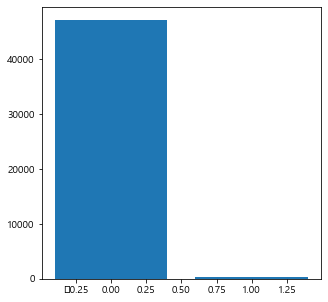

0    0.994177
1    0.005823
Name: EV, dtype: float64


In [101]:
plt.bar([0, 1], material['EV'].value_counts())
plt.show()
print(material['EV'].value_counts()/len(material))

### 앙상블 모델 비교

In [131]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score as acc

data = material[material.columns[1:-1]]
target = material['EV']

from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(data, target, random_state = 56)

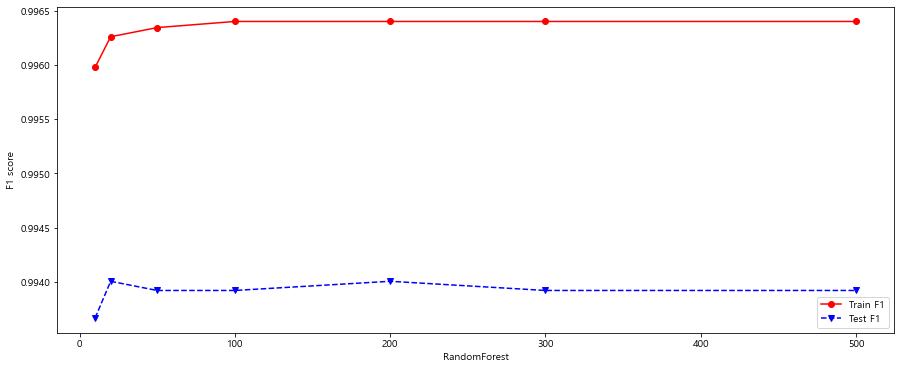

In [141]:
from sklearn import ensemble

trainF1 = []
testF1 = []

X_train, Y_train, X_test, Y_test = data_train, target_train, data_test, target_test

numBaseClassifiers = [10, 20, 50, 100, 200, 300, 500,]
testF1 = []
bestf1 = []

for k in numBaseClassifiers:
    clf = ensemble.RandomForestClassifier(n_estimators=k) # class_weight={0:1, 1:9}
    clf.fit(data_train, target_train)
    Y_predTrain = clf.predict(data_train)
    Y_predTest = clf.predict(data_test)
    trainF1.append(f1_score(target_train, Y_predTrain, average='micro'))
    testF1.append(f1_score(target_test, Y_predTest, average='micro'))

plt.figure(figsize=(15, 6))
plt.plot(numBaseClassifiers, trainF1, 'ro-', numBaseClassifiers, testF1, 'bv--')
plt.legend(['Train F1', 'Test F1'])
plt.xlabel('RandomForest')
plt.ylabel('F1 score')
plt.show()

In [157]:
df_train = data_train.copy()
df_train['EV'] = target_train
df_train['predTrain'] = Y_predTrain
df_train.head()

print("train_set 에서 충전소가 있는 곳 :", len(df_train[(df_train['EV'] == 1)]))
print("train_set에서 충전소가 없는 곳 :", len(df_train[(df_train['EV'] == 0)]))
print("충전소가 있다고 정확히 분류 :", len(df_train[(df_train['EV'] == 1) & (df_train['predTrain'] == 1)]))
print("충전소가 없는데 있다고 분류 :", len(df_train[(df_train['EV'] == 0) & (df_train['predTrain'] == 1)]))
print("충전소가 있는데 없다고 분류 :", len(df_train[(df_train['EV'] == 1) & (df_train['predTrain'] == 0)]))
print()

df_test = data_test.copy()
df_test['EV'] = target_test
df_test['predTest'] = Y_predTest
df_test.head()

print("test_set 에서 충전소가 있는 곳 :", len(df_test[(df_test['EV'] == 1)]))
print("test_set에서 충전소가 없는 곳 :", len(df_test[(df_test['EV'] == 0)]))
print("충전소가 있다고 정확히 분류 :", len(df_test[(df_test['EV'] == 1) & (df_test['predTest'] == 1)]))
print("충전소가 없는데 있다고 분류 :", len(df_test[(df_test['EV'] == 0) & (df_test['predTest'] == 1)]))
print("충전소가 있는데 없다고 분류 :", len(df_test[(df_test['EV'] == 1) & (df_test['predTest'] == 0)]))

train_set 에서 충전소가 있는 곳 : 219
train_set에서 충전소가 없는 곳 : 35328
충전소가 있다고 정확히 분류 : 93
충전소가 없는데 있다고 분류 : 2
충전소가 있는데 없다고 분류 : 126

test_set 에서 충전소가 있는 곳 : 57
test_set에서 충전소가 없는 곳 : 11792
충전소가 있다고 정확히 분류 : 4
충전소가 없는데 있다고 분류 : 19
충전소가 있는데 없다고 분류 : 53


estimators = 1
충전소가 없는데 있다고 분류 : 153
충전소가 있는데 없다고 분류 : 174 / 276

estimators = 2
충전소가 없는데 있다고 분류 : 27
충전소가 있는데 없다고 분류 : 207 / 276

estimators = 3
충전소가 없는데 있다고 분류 : 62
충전소가 있는데 없다고 분류 : 180 / 276

estimators = 4
충전소가 없는데 있다고 분류 : 41
충전소가 있는데 없다고 분류 : 197 / 276

estimators = 5
충전소가 없는데 있다고 분류 : 52
충전소가 있는데 없다고 분류 : 170 / 276

estimators = 6
충전소가 없는데 있다고 분류 : 74
충전소가 있는데 없다고 분류 : 180 / 276

estimators = 7
충전소가 없는데 있다고 분류 : 52
충전소가 있는데 없다고 분류 : 160 / 276

estimators = 8
충전소가 없는데 있다고 분류 : 45
충전소가 있는데 없다고 분류 : 177 / 276

estimators = 9
충전소가 없는데 있다고 분류 : 56
충전소가 있는데 없다고 분류 : 159 / 276

estimators = 10
충전소가 없는데 있다고 분류 : 51
충전소가 있는데 없다고 분류 : 158 / 276

estimators = 11
충전소가 없는데 있다고 분류 : 56
충전소가 있는데 없다고 분류 : 150 / 276

estimators = 12
충전소가 없는데 있다고 분류 : 47
충전소가 있는데 없다고 분류 : 156 / 276

estimators = 13
충전소가 없는데 있다고 분류 : 60
충전소가 있는데 없다고 분류 : 151 / 276

estimators = 14
충전소가 없는데 있다고 분류 : 52
충전소가 있는데 없다고 분류 : 153 / 276

estimators = 15
충전소가 없는데 있다고 분류 : 40
충전소가 있는데 없다고 분류 : 155 / 276

estimators = 16
충전

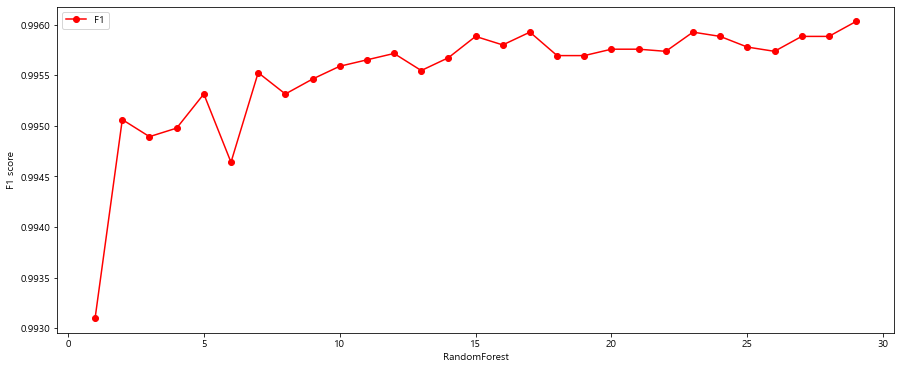

In [189]:
from sklearn import ensemble

F1 = []

numBaseClassifiers = range(1, 30, 1)

for k in numBaseClassifiers:
    clf = ensemble.RandomForestClassifier(n_estimators=k, class_weight={0:1, 1:9}) # class_wei ght={0:1, 1:9}
    clf.fit(data, target)
    Y_pred = clf.predict(data)
    F1.append(f1_score(target, Y_pred, average='micro'))
    
    df = data.copy()
    df['EV'] = target
    df['pred'] = Y_pred
    df.head()

    print("estimators =", k)
    print("충전소가 없는데 있다고 분류 :", len(df[(df['EV'] == 0) & (df['pred'] == 1)]))
    print("충전소가 있는데 없다고 분류 :", len(df[(df['EV'] == 1) & (df['pred'] == 0)]), "/", len(df[(df['EV'] == 1)]))
    print()
    

plt.figure(figsize=(15, 6))
plt.plot(numBaseClassifiers, F1, 'ro-')
plt.legend(['F1'])
plt.xlabel('RandomForest')
plt.ylabel('F1 score')
plt.show()

In [304]:
df = data.copy()
df['EV'] = target
df['pred'] = Y_pred
df.head()

print("충전소가 없는데 있다고 분류 :", len(df[(df['EV'] == 0) & (df['pred'] == 1)]))
print("충전소가 있는데 없다고 분류 :", len(df[(df['EV'] == 1) & (df['pred'] == 0)]), "/", len(df[(df['EV'] == 1)]))

충전소가 없는데 있다고 분류 : 45
충전소가 있는데 없다고 분류 : 143 / 276


In [305]:
Y = clf.predict(material[material.columns[1:-1]])

df = material.copy()
df['pred'] = Y

idx = df[(df['EV'] == 0) & (df['pred'] == 1)].index

for i in df[df['pred'] == 1].index:
    df['pred'].loc[i] = 0
for i in idx:
    df['pred'].loc[i] = 1
    
df = df[df['pred'] == 1]

df.head()

geometry  인구수  건축물수  주차장수  주유소  \
141  POLYGON ((975900.00000 1835100.00000, 975900.0...  247     1     0    0   
476  POLYGON ((977100.00000 1832500.00000, 977100.0...  651     3     0    0   
545  POLYGON ((975700.00000 1835100.00000, 975700.0...  381     2     0    0   
573  POLYGON ((977200.00000 1835600.00000, 977200.0...  208     1     0    0   
733  POLYGON ((979400.00000 1836800.00000, 979400.0...  232     1     0    0   

     주차구획수  교통량  교육연구시설  주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  \
141      0  0.0       0    0       0     0     0     0     0        0   0   
476      0  0.0       0    0       0     0     0     0     0        0   0   
545      0  0.0       0    0       0     0     0     0     0        0   0   
573      0  0.0       0    0       0     0     0     0     0        0   0   
733      0  0.0       0    0       0     0     0     0     0        0   0   

     pred  
141     1  
476     1  
545     1  
573     1  
733     1

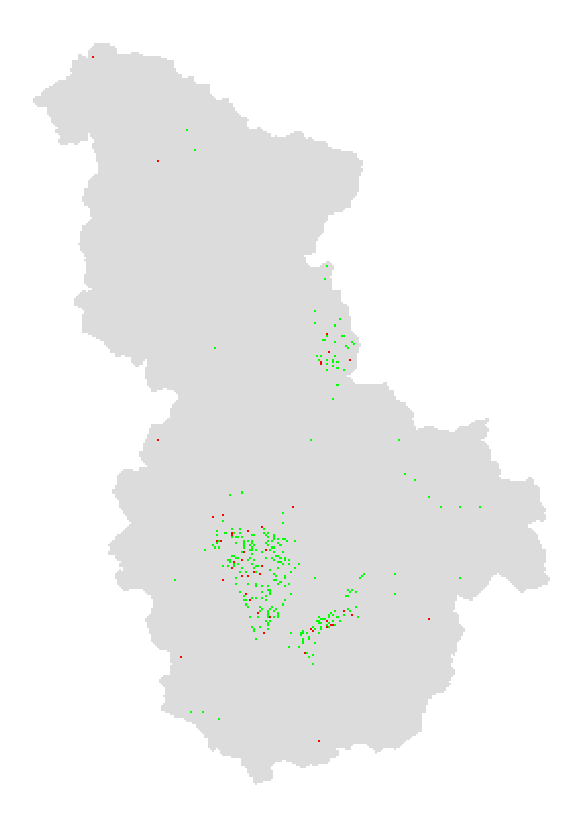

In [192]:
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white') ## 캔버스 색상 설정

material['geometry'].plot(ax=ax1, color='gainsboro')
material[material['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
df.plot(ax=ax1, column='pred', color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [306]:
geometry = df.geometry.copy().astype('string')
geometry[:1]

141    POLYGON ((975900 1835100, 975900 1835200, 9760...
Name: geometry, dtype: string

In [311]:
#### 격자 중심점의 위도/경도 찾기

#### polygon 데이터를 슬라이싱하기 위해 string으로 변환
polygon = df['geometry'].astype('string')

loc = []

# 한 격자당 위도 변화
length_100m = (36.73376199366808 - 36.40675835257603) / 364

# 한 격자당 경도 변화
width_100m = (127.4092754044858 - 127.12765872447403) / 254

for i, P in enumerate(polygon):
    lat = (int(P.split()[2][:-1]) + 50 - 1823200) / 100 * length_100m + 36.40675835257603
    long = (int(P.split()[1][2:]) + 50 - 966700) / 100 * width_100m + 127.12765872447403
    
    loc.append((lat, long))

#### 중심점을 GCS 열로 생성

df['GCS'] = loc
df.head(3)

geometry  인구수  건축물수  주차장수  주유소  \
141  POLYGON ((975900.00000 1835100.00000, 975900.0...  247     1     0    0   
476  POLYGON ((977100.00000 1832500.00000, 977100.0...  651     3     0    0   
545  POLYGON ((975700.00000 1835100.00000, 975700.0...  381     2     0    0   

     주차구획수  교통량  교육연구시설  주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  \
141      0  0.0       0    0       0     0     0     0     0        0   0   
476      0  0.0       0    0       0     0     0     0     0        0   0   
545      0  0.0       0    0       0     0     0     0     0        0   0   

     pred       x                                      GCS  
141     1  975900  (36.51411256991257, 127.23021597999012)  
476     1  977100  (36.49075516697742, 127.24352070503005)  
545     1  975700   (36.51411256991257, 127.2279985258168)

In [312]:
geometry = df.geometry.copy().astype('string')
x = []
for i, g in enumerate(geometry):
    x.append(g.split()[1][2:])
df['x'] = list(map(int, x))

x.sort()
print(x[0:3])

['969600', '972800', '972800']


In [313]:
df[df['x']<=972800]

geometry  인구수  건축물수  주차장수  주유소  \
2277  POLYGON ((972800.00000 1853800.00000, 972800.0...   27     9     0    0   
2678  POLYGON ((969600.00000 1858900.00000, 969600.0...   26    12     0    0   
5259  POLYGON ((972800.00000 1840100.00000, 972800.0...    0     1     0    0   

      주차구획수  교통량  교육연구시설  주거지  농축산업시설  창고시설  편의시설  생산시설  님비시설  자동차관련시설  EV  \
2277      0  0.0       0    0       0     0     0     0     0        0   0   
2678      0  0.0       0    0       0     0     0     0     0        0   0   
5259      0  0.0       0    2       0     0     0     0     0        0   0   

      pred       x                                       GCS  
2277     1  972800   (36.68210619871535, 127.19584544030366)  
2678     1  969600  (36.727922642934296, 127.16036617353052)  
5259     1  972800   (36.55903065248016, 127.19584544030366)

estimators = 50 , max_depth = 1
충전소가 없는데 있다고 분류 : 724
충전소가 있는데 없다고 분류 : 165 / 276

estimators = 50 , max_depth = 2
충전소가 없는데 있다고 분류 : 351
충전소가 있는데 없다고 분류 : 177 / 276

estimators = 50 , max_depth = 3
충전소가 없는데 있다고 분류 : 304
충전소가 있는데 없다고 분류 : 136 / 276

estimators = 50 , max_depth = 5
충전소가 없는데 있다고 분류 : 75
충전소가 있는데 없다고 분류 : 130 / 276

estimators = 50 , max_depth = 10
충전소가 없는데 있다고 분류 : 75
충전소가 있는데 없다고 분류 : 130 / 276

estimators = 50 , max_depth = 20
충전소가 없는데 있다고 분류 : 75
충전소가 있는데 없다고 분류 : 130 / 276

estimators = 100 , max_depth = 1
충전소가 없는데 있다고 분류 : 701
충전소가 있는데 없다고 분류 : 164 / 276

estimators = 100 , max_depth = 2
충전소가 없는데 있다고 분류 : 280
충전소가 있는데 없다고 분류 : 154 / 276

estimators = 100 , max_depth = 3
충전소가 없는데 있다고 분류 : 95
충전소가 있는데 없다고 분류 : 132 / 276

estimators = 100 , max_depth = 5
충전소가 없는데 있다고 분류 : 84
충전소가 있는데 없다고 분류 : 129 / 276

estimators = 100 , max_depth = 10
충전소가 없는데 있다고 분류 : 75
충전소가 있는데 없다고 분류 : 130 / 276

estimators = 100 , max_depth = 20
충전소가 없는데 있다고 분류 : 75
충전소가 있는데 없다고 분류 : 130 / 276

e

Text(0, 0.5, 'F1 score')

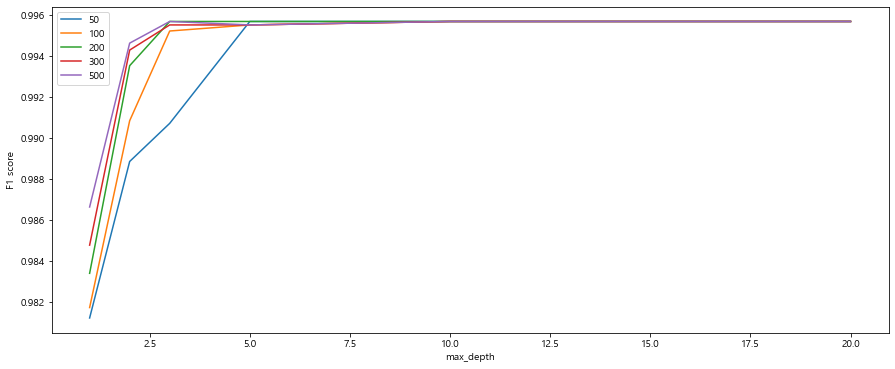

In [320]:
numBaseClassifiers = [50, 100, 200, 300, 500]
max_depths = [1, 2, 3, 5, 10, 20]
F1 = []

plt.figure(figsize=(15, 6))
for k in numBaseClassifiers:
    for maxdepth in max_depths:
        clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth, class_weight={0:1, 1:9}), n_estimators=k)
        clf.fit(data, target)
        #Y_predTrain = clf.predict(data_train)
        Y_pred = clf.predict(data)
        F1.append(f1_score(target, Y_pred, average='micro'))

        df = data.copy()
        df['EV'] = target
        df['pred'] = Y_pred
        df.head()

        print("estimators =", k, ", max_depth =", maxdepth)
        print("충전소가 없는데 있다고 분류 :", len(df[(df['EV'] == 0) & (df['pred'] == 1)]))
        print("충전소가 있는데 없다고 분류 :", len(df[(df['EV'] == 1) & (df['pred'] == 0)]), "/", len(df[(df['EV'] == 1)]))
        print()
        
        
    plt.plot(max_depths, F1)
    F1 = []

plt.legend(numBaseClassifiers)
plt.xlabel('max_depth')
plt.ylabel('F1 score')

estimators = 100 , max_depth = 20
충전소가 없는데 있다고 분류 : 1
충전소가 있는데 없다고 분류 : 177 / 276

estimators = 100 , max_depth = 50
충전소가 없는데 있다고 분류 : 2
충전소가 있는데 없다고 분류 : 170 / 276

estimators = 100 , max_depth = 100
충전소가 없는데 있다고 분류 : 2
충전소가 있는데 없다고 분류 : 171 / 276

estimators = 100 , max_depth = 200
충전소가 없는데 있다고 분류 : 3
충전소가 있는데 없다고 분류 : 169 / 276

estimators = 200 , max_depth = 20
충전소가 없는데 있다고 분류 : 1
충전소가 있는데 없다고 분류 : 174 / 276

estimators = 200 , max_depth = 50
충전소가 없는데 있다고 분류 : 4
충전소가 있는데 없다고 분류 : 168 / 276

estimators = 200 , max_depth = 100
충전소가 없는데 있다고 분류 : 2
충전소가 있는데 없다고 분류 : 170 / 276

estimators = 200 , max_depth = 200
충전소가 없는데 있다고 분류 : 1
충전소가 있는데 없다고 분류 : 171 / 276

estimators = 300 , max_depth = 20
충전소가 없는데 있다고 분류 : 1
충전소가 있는데 없다고 분류 : 176 / 276

estimators = 300 , max_depth = 50
충전소가 없는데 있다고 분류 : 0
충전소가 있는데 없다고 분류 : 172 / 276

estimators = 300 , max_depth = 100
충전소가 없는데 있다고 분류 : 1
충전소가 있는데 없다고 분류 : 171 / 276

estimators = 300 , max_depth = 200
충전소가 없는데 있다고 분류 : 1
충전소가 있는데 없다고 분류 : 171 / 276

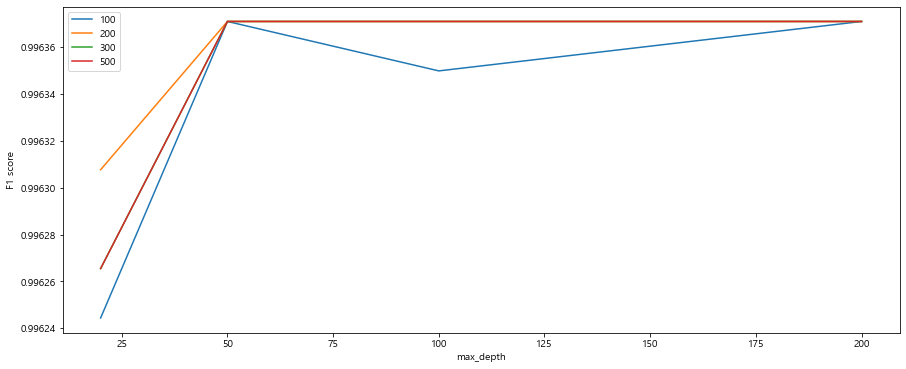

In [318]:
numBaseClassifiers = [100, 200, 300, 500]
max_depths = [20, 50, 100, 200]
F1 = []

plt.figure(figsize=(15, 6))
for k in numBaseClassifiers:
    for maxdepth in max_depths:
        clf = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=maxdepth, class_weight={0:1, 1:9}), n_estimators=k)
        clf.fit(data, target)
        #Y_predTrain = clf.predict(data_train)
        Y_pred = clf.predict(data)
        F1.append(f1_score(target, Y_pred, average='micro'))
        
        df = data.copy()
        df['EV'] = target
        df['pred'] = Y_pred
        df.head()

        print("estimators =", k, ", max_depth =", maxdepth)
        print("충전소가 없는데 있다고 분류 :", len(df[(df['EV'] == 0) & (df['pred'] == 1)]))
        print("충전소가 있는데 없다고 분류 :", len(df[(df['EV'] == 1) & (df['pred'] == 0)]), "/", len(df[(df['EV'] == 1)]))
        print()
        
    plt.plot(max_depths, F1)
    F1 = []
    
plt.legend(numBaseClassifiers)
plt.xlabel('max_depth')
plt.ylabel('F1 score')

bestf1.append(max(testF1))

In [ ]:
# 정규화 -> 이상치 제거 -> 다른 도시 학습

간단하게 학습을 했을 때, 기존에 있음에도 없어야한다고 분류한 케이스도 있음 -> 이는 어떻게...?

우리는 없는 곳을 있는 곳으로 분류할 수 있도록 해야함...
-> 즉, train_test_split으로 학습시, train은 1에 가깝게, test는 적당히 더 낮아지는 것이 좋은 모델이라고 볼 수 있음.
= 오버피팅을 유도!

군집분석으로 근거를 확보해보자
다른 분류 모델로 학습도 해보자!